Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 21

In [1]:
num_days_R_prediction=21

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=12 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
242                           NaN             Timor-Leste  -8.874217   
243                           NaN                    Togo   8.619500   
244                           NaN     Trinidad and Tobago  10.691800   
245                           NaN                 Tunisia  33.886917   
246                           NaN                  Turkey  38.963700   
247                           NaN           United States  40.000000   
248                           NaN                  Uganda   1.373333   
249                           NaN                 Ukraine  48.379400   
250                           NaN    United Arab Emirates  23.424076   
251                      Anguilla          United Kingdom  18.220600   
252                       Bermuda          United Kingdom  32.307800   
253        British Virgin Islands          United Kingdom  18.420700   
254                Cayman Islands          United Kingdom  19.313300   
255               Channel Islands          United Kingdom  49.372300   
256   Falkland Islands (Malvinas)          United Kingdom -51.796300   
257                     Gibraltar          United Kingdom  36.140800   
258                   Isle of Man          United Kingdom  54.236100   
259                    Montserrat          United Kingdom  16.742498   
260      Turks and Caicos Islands          United Kingdom  21.694000   
261                           NaN          United Kingdom  55.378100   
262                           NaN                 Uruguay -32.522800   
263                           NaN              Uzbekistan  41.377491   
264                           NaN                 Vanuatu -15.376700   
265                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
248                           NaN             Timor-Leste  -8.874217   
249                           NaN                    Togo   8.619500   
250                           NaN     Trinidad and Tobago  10.691800   
251                           NaN                 Tunisia  33.886917   
252                           NaN                  Turkey  38.963700   
253                           NaN           United States  40.000000   
254                           NaN                  Uganda   1.373333   
255                           NaN                 Ukraine  48.379400   
256                           NaN    United Arab Emirates  23.424076   
257                      Anguilla          United Kingdom  18.220600   
258                       Bermuda          United Kingdom  32.307800   
259        British Virgin Islands          United Kingdom  18.420700   
260                Cayman Islands          United Kingdom  19.313300   
261               Channel Islands          United Kingdom  49.372300   
262   Falkland Islands (Malvinas)          United Kingdom -51.796300   
263                     Gibraltar          United Kingdom  36.140800   
264                   Isle of Man          United Kingdom  54.236100   
265                    Montserrat          United Kingdom  16.742498   
266      Turks and Caicos Islands          United Kingdom  21.694000   
267                           NaN          United Kingdom  55.378100   
268                           NaN                 Uruguay -32.522800   
269                           NaN              Uzbekistan  41.377491   
270                           NaN                 Vanuatu -15.376700   
271                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  11/30/20  12/1/20  12/2/20  \
185        0        0        0        0  ...        10       10       10   
186        0        0        0        0  ...    105940   106765   107565   
187        0        0        0        0  ...      2304     2323     2343   
188        0        0        0        0  ...         3        3        3   
189        0        0        0        0  ...         0        0        0   
190        0        0        0        0  ...       499      504      510   
191        0        0        0        0  ...      5846     5915     5985   
192        0        0        0        0  ...       131      131      132   
193        0        0        0        0  ...       151      151      151   
194        0        0        0        0  ...      1508     1529     1538   

     12/3/20  12/4/20  12/5/20  12/6/20  12/7/20   Population           region  
185       10       10       10       10       10           NaN   Mauritius_nan  
186   108173   108863   109456   109717   110074   128,640,794      Mexico_nan  
187     2363     2384     2403     2419     2438     4,035,942     Moldova_nan  
188        3        3        3        3        3        39,183      Monaco_nan  
189        0        0        0        0        0           NaN    Mongolia_nan  
190      516      522      530      533      543       622 500  Montenegro_nan  
191     6063     6136     6184     6245     6320    36,817,128     Morocco_nan  
192      132      133      133      133      136    31,542,919  Mozambique_nan  
193      151      152      152      152      152           NaN     Namibia_nan  
194     1551     1567     1577     1594     1614    29,300,000       Nepal_nan  

[10 rows x 327 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/30/20  \
175        0        0        0        0        0        0  ...     13729   
176        0        0        0        0        0        0  ...     13535   
177        0        0        0        0        0        0  ...    214521   
178        0        0        0        0        0        0  ...      4692   
179        0        0        0        0        0        0  ...       157   
180        0        0        0        0        0        0  ...      1151   
181        0        0        0        0        0        0  ...       947   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...      1962   
184        0        0        0        0        0        0  ...      4225   

     12/1/20  12/2/20  12/3/20  12/4/20  12/5/20  12/6/20  12/7/20  \
175    13778    14014    14030    14160    14343    14416    14429   
176    13600    13697    13774    13874    13908    13939    13949   
177   216594   218161   220272   221847   224053   225805   227433   
178     4705     4718     4733     4746     4763     4788     4801   
179      157      157      158      158      158      158      158   
180     1191     1218     1245     1292     1328     1337     1352   
181      964      973      993     1007     1017     1017     1030   
182        0        0        0        0        0        0        0   
183     1963     1974     1983     1994     1997     1998     2006   
184     4225     4225     4225     4225     4225     4225     4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176           NaN                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180       158,665                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 327 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  11/30/20  12/1/20  12/2/20  \
185        0        0        0        0  ...       504      505      508   
186        0        0        0        0  ...   1113543  1122362  1133613   
187        0        0        0        0  ...    107364   108863   110580   
188        0        0        0        0  ...       609      617      621   
189        0        0        0        0  ...       801      812      819   
190        0        0        0        0  ...     35265    35849    36351   
191        0        0        0        0  ...    356336   359844   364190   
192        0        0        0        0  ...     15701    15770    15866   
193        0        0        0        0  ...     14380    14416    14477   
194        0        1        1        1  ...    233452   233452   236246   

     12/3/20  12/4/20  12/5/20  12/6/20  12/7/20   Population           region  
185      508      508      508      508      511           NaN   Mauritius_nan  
186  1144643  1156770  1168395  1175850  1182249   128,640,794      Mexico_nan  
187   112307   113829   115557   116365   117495     4,035,942     Moldova_nan  
188      630      630      637      638      641        39,183      Monaco_nan  
189      831      842      849      887      888           NaN    Mongolia_nan  
190    36932    37467    37879    38246    38562       622 500  Montenegro_nan  
191   368624   372620   376738   379657   381188    36,817,128     Morocco_nan  
192    15918    16038    16133    16244    16326    31,542,919  Mozambique_nan  
193    14599    14804    14950    15078    15219           NaN     Namibia_nan  
194   237589   238861   239885   240981   241995    29,300,000       Nepal_nan  

[10 rows x 327 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Saint Lucia  13.909400  -60.978900   
221            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
222            NaN                             Samoa -13.759000 -172.104600   
223            NaN                        San Marino  43.942400   12.457800   
224            NaN             Sao Tome and Principe   0.186400    6.613100   
225            NaN                      Saudi Arabia  23.885942   45.079162   
226            NaN                           Senegal  14.497400  -14.452400   
227            NaN                            Serbia  44.016500   21.005900   
228            NaN                        Seychelles  -4.679600   55.492000   
229            NaN                      Sierra Leone   8.460555  -11.779889   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/30/20  \
220        0        0        0        0        0        0  ...       259   
221        0        0        0        0        0        0  ...        85   
222        0        0        0        0        0        0  ...         2   
223        0        0        0        0        0        0  ...      1612   
224        0        0        0        0        0        0  ...       991   
225        0        0        0        0        0        0  ...    357360   
226        0        0        0        0        0        0  ...     16089   
227        0        0        0        0        0        0  ...    175438   
228        0        0        0        0        0        0  ...       183   
229        0        0        0        0        0        0  ...      2412   

     12/1/20  12/2/20  12/3/20  12/4/20  12/5/20  12/6/20  12/7/20  \
220      259      261      262      262      265      265      270   
221       85       85       87       87       87       87       87   
222        2        2        2        2        2        2        2   
223     1650     1687     1714     1756     1789     1789     1800   
224      996      997      997      999      999      999     1002   
225   357623   357872   358102   358336   358526   358713   358922   
226    16107    16173    16217    16297    16397    16477    16553   
227   183437   191356   199158   206940   213843   219652   226209   
228      183      183      183      184      184      184      184   
229     2413     2416     2416     2420     2420     2426     2428   

      Population                                 region  
220           NaN                       Saint Lucia_nan  
221           NaN  Saint Vincent and the Grenadines_nan  
222           NaN                             Samoa_nan  
223        33,916                        San Marino_nan  
224           NaN             Sao Tome and Principe_nan  
225    34,695,447                      Saudi Arabia_nan  
226           NaN                           Senegal_nan  
227     8,744,671                            Serbia_nan  
228           NaN                        Seychelles_nan  
229           NaN                      Sierra Leone_nan  

[10 rows x 327 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

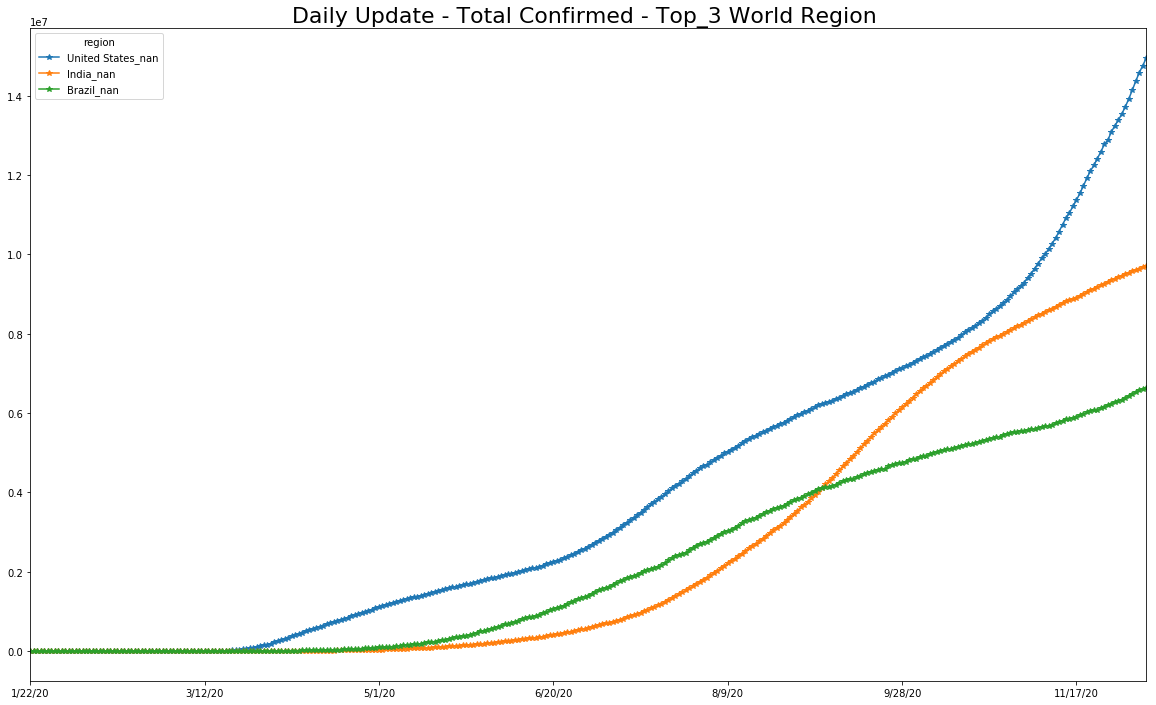

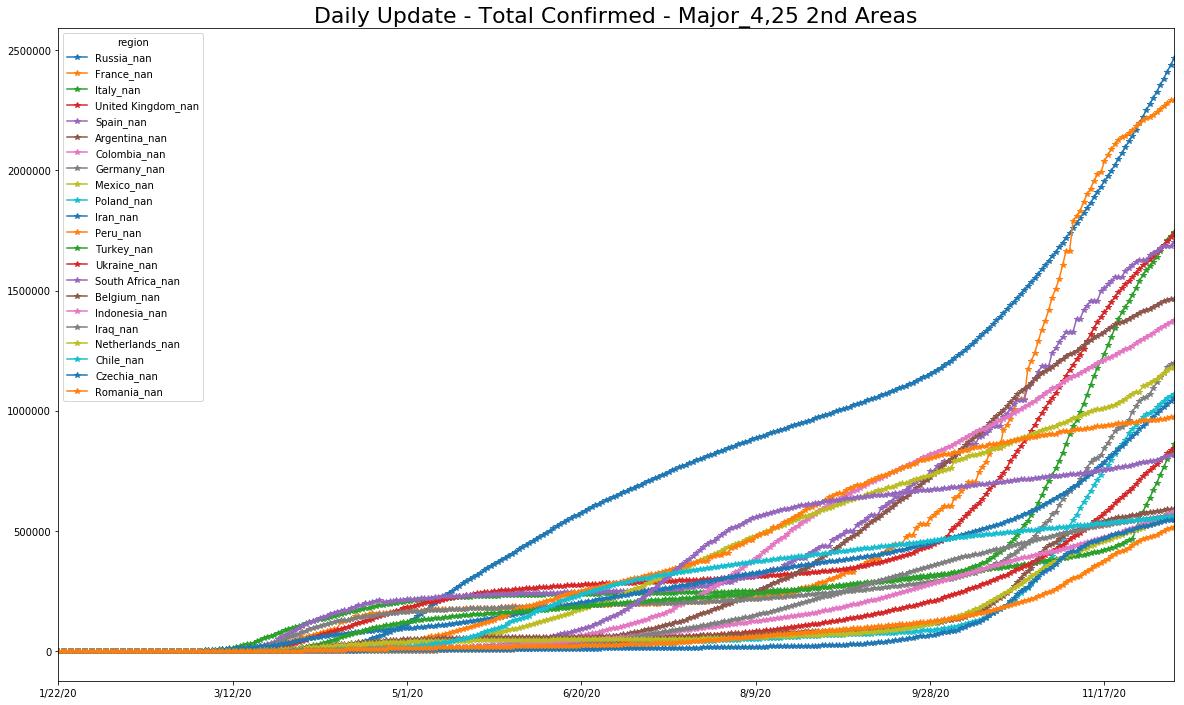

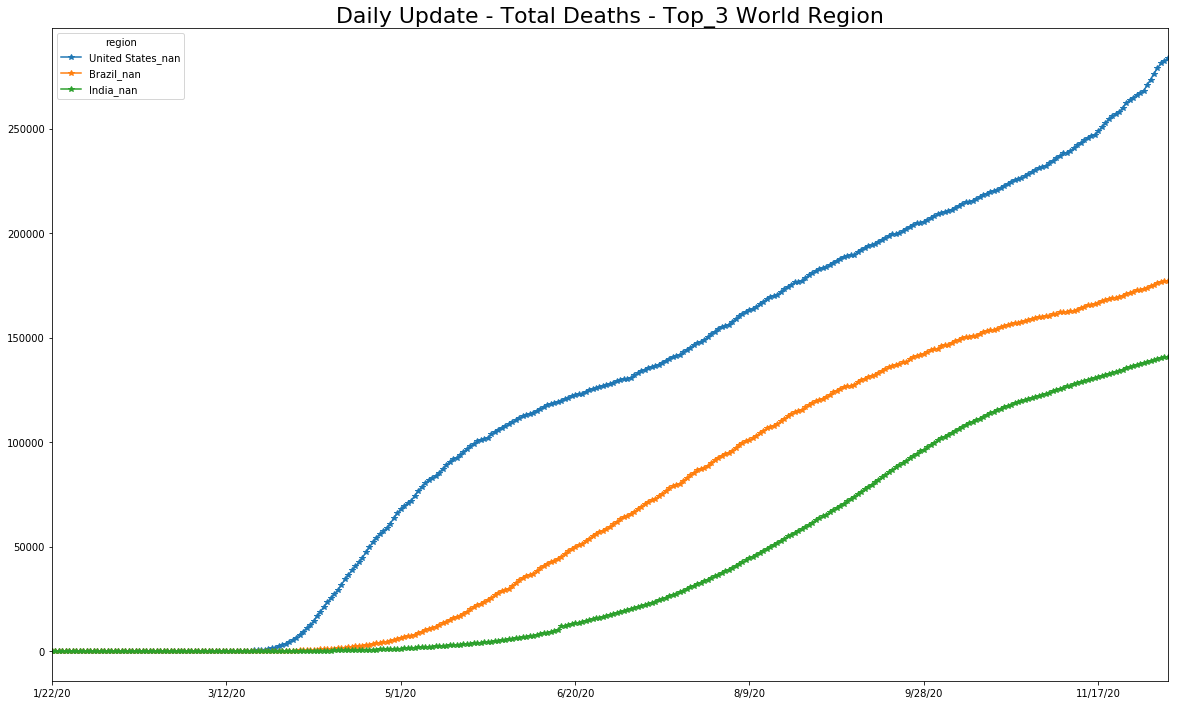

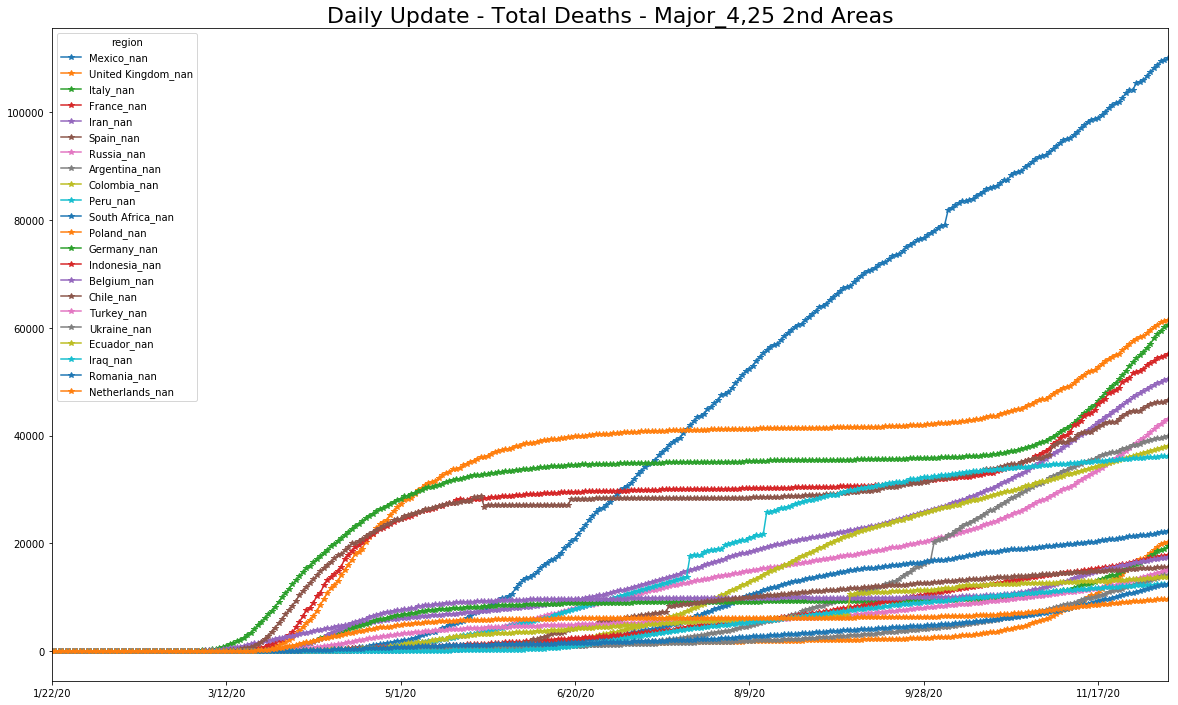

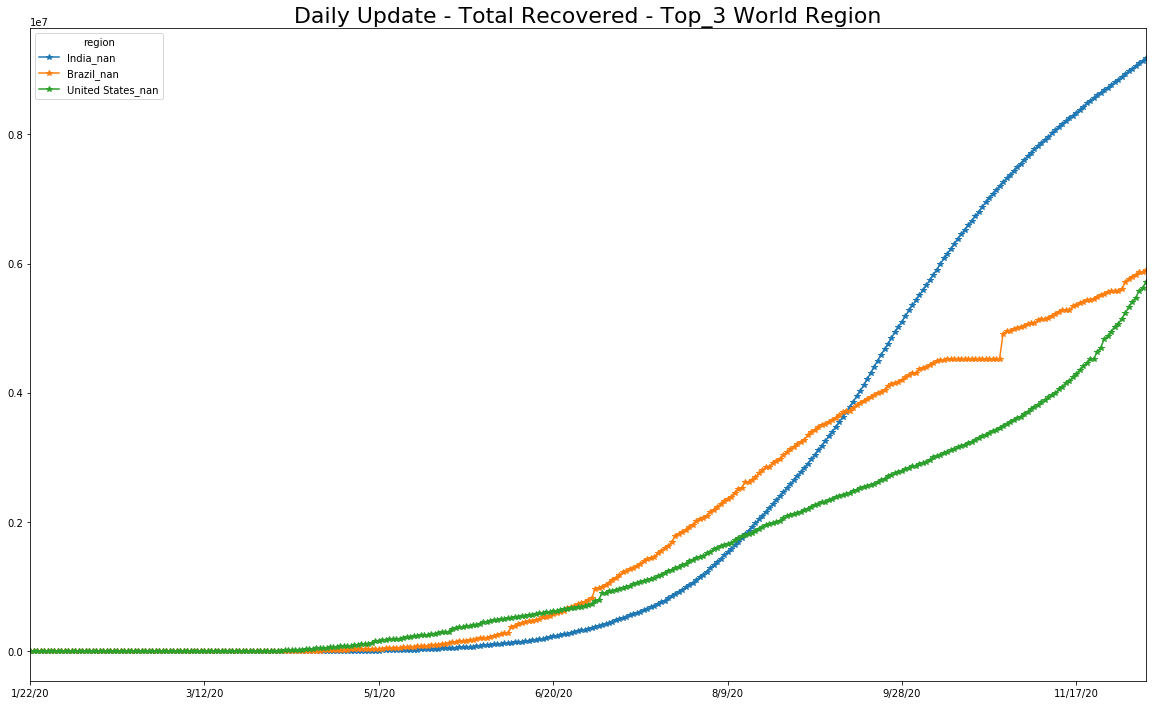

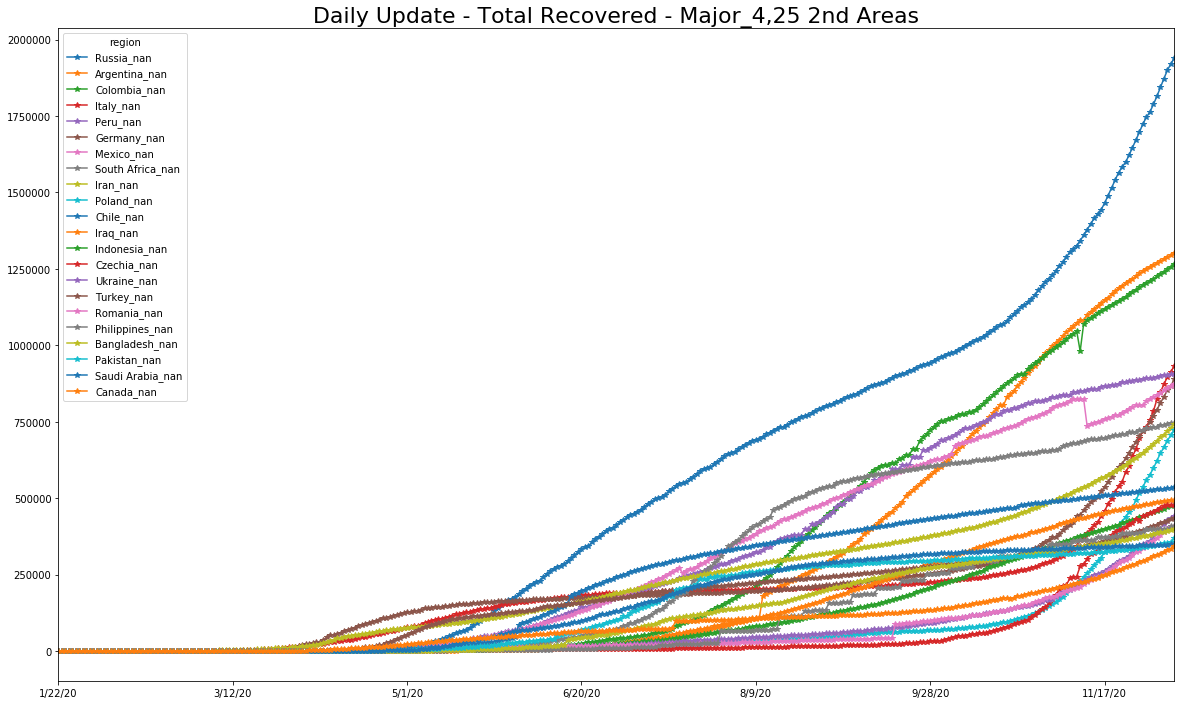

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/12/08


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34984         3752        20770          862         576   
7/16/20            35060         3851        21355          877         607   
7/17/20            35219         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
7/15/20  ...         1009           14581            0          10428   
7/16/20  ...         1026           15066            0          10854   
7/17/20  ...         1037           15607            0          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 272 columns]

In [24]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
12/4/20            46837        41302        86730         6955       15493   
12/5/20            47072        42148        87502         7005       15536   
12/6/20            47306        42988        88252         7050       15591   
12/7/20            47516        43683        88825         7084       15648   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
12/4/20                      144        1454631       139692   
12/5/20                      144        1459832       140959   
12/6/20                      144        1463110       141937   
12/7/20                      146        1466309       142344   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
12/4/20                                     117                       4605   
12/5/20                                     117                       4610   
12/6/20                                     117                       4614   
12/7/20                                     117                       4620   

region   ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
12/4/20  ...         6731           73751            1         103877   
12/5/20  ...         6965           73751            1         104177   
12/6/20  ...         7303           74053            1         104442   
12/7/20  ...         7505           74053            1         104904   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
12/4/20         1361                   94676                  10       2267   
12/5/20         1365                   96098                  10       2304   
12/6/20         1366                   98038                  10       2337   
12/7/20         1367                   99758                  10       2383   

region   Zambia_nan  Zimbabwe_nan  
12/4/20       17857         10547  
12/5/20       17898         10617  
12/6/20       17916         10718  
12/7/20       17931         10839  

[4 rows x 272 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
8157 2020-05-10  Vietnam_nan  26.9  33.0
8158 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35060             0             0   
2     2020-07-17  Afghanistan_nan      35219            76             0   
3     2020-07-18  Afghanistan_nan      35279           159             0   
4     2020-07-19  Afghanistan_nan      35453            60           295   
5     2020-07-20  Afghanistan_nan      35493           174           393   
6     2020-07-21  Afghanistan_nan      35605            40           274   
7     2020-07-22  Afghanistan_nan      35717           112           326   
8     2020-07-23  Afghanistan_nan      35918           112           264   
9     2020-07-24  Afghanistan_nan      35978           201           425   
10    2020-07-25  Afghanistan_nan      36026            60           373   
11    2020-07-26  Afghanistan_nan      36147            48           309   
12    2020-07-27  Afghanistan_nan      36253           121           229   
13    2020-07-28  Afghanistan_nan      36358           106           275   
14    2020-07-29  Afghanistan_nan      36463           105           332   
15    2020-07-30  Afghanistan_nan      36532           105           316   
16    2020-07-31  Afghanistan_nan      36665            69           279   
17    2020-08-01  Afghanistan_nan      36700           133           307   
18    2020-08-02  Afghanistan_nan      36701            35           237   
19    2020-08-03  Afghanistan_nan      36737             1           169   
20    2020-08-04  Afghanistan_nan      36773            36            72   
21    2020-08-05  Afghanistan_nan      36820            36            73   
22    2020-08-06  Afghanistan_nan      36928            47           119   
23    2020-08-07  Afghanistan_nan      37006           108           191   
24    2020-08-08  Afghanistan_nan      37046            78           233   
25    2020-08-09  Afghanistan_nan      37083            40           226   
26    2020-08-10  Afghanistan_nan      37153            37           155   
27    2020-08-11  Afghanistan_nan      37260            70           147   
28    2020-08-12  Afghanistan_nan      37336           107           214   
29    2020-08-13  Afghanistan_nan      37422            76           253   
30    2020-08-14  Afghanistan_nan      37497            86           269   
...          ...              ...        ...           ...           ...   
40836 2020-11-09     Zimbabwe_nan       8561            33            87   
40837 2020-11-10     Zimbabwe_nan       8610            30            90   
40838 2020-11-11     Zimbabwe_nan       8667            49           112   
40839 2020-11-12     Zimbabwe_nan       8696            57           136   
40840 2020-11-13     Zimbabwe_nan       8765            29           135   
40841 2020-11-14     Zimbabwe_nan       8786            69           155   
40842 2020-11-15     Zimbabwe_nan       8829            21           119   
40843 2020-11-16     Zimbabwe_nan       8897            43           133   
40844 2020-11-17     Zimbabwe_nan       8945            68           132   
40845 2020-11-18     Zimbabwe_nan       8981            48           159   
40846 2020-11-19     Zimbabwe_nan       9046            36           152   
40847 2020-11-20     Zimbabwe_nan       9120            65           149   
40848 2020-11-21     Zimbabwe_nan       9172            74           175   
40849 2020-11-22     Zimbabwe_nan       9220            52           191   
40850 2020-11-23     Zimbabwe_nan       9308            48           174   
40851 2020-11-24     Zimbabwe_nan       9398            88           188   
40852 2020-11-25     Zimbabwe_nan       9508            90           226   
40853 2020-11-26     Zimbabwe_nan       9623           110           288   
40854 2020-11-27     Zimbabwe_nan       9714           115           315   
40855 2020-11-28     Zimbabwe_nan       9822            91           316   
40856 2020-11-29     Zimbabwe_nan       9822           108  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
40865 2020-12-08  Zimbabwe_nan          0           121           292   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
40865           889         101.129035         102.768655         108.934774   

       last_day  kalman_prediction  population  infected_rate  min  max  
40865     10839            10974.0    14862924       0.000007  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
40865 2020-12-08  Zimbabwe_nan          0           121           292   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
40865           889         101.129035         102.768655         108.934774   

       last_day  kalman_prediction  population  infected_rate  min  max  
40865     10839            10974.0    14862924       0.000007  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
39981  2020-12-06  Zimbabwe_nan      10718            70           488   
39982  2020-12-07  Zimbabwe_nan      10839           101           294   
39983  2020-12-08  Zimbabwe_nan          0           121           292   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
39981           795         100.663791         104.817948         108.094176   
39982           896         100.951399         102.820510         109.122480   
39983           889         101.129035         102.768655         108.934774   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
39981                10617  ...    14862924       0.000007  NaN  NaN   
39982                10718  ...    14862924       0.000007  NaN  NaN   
39983                10839  ...    14862924       0.000007  NaN  NaN   

       population_percentage : infected_rate confirmed  \
39981                                         0.000714   
39982                                         0.000721   
39983                                         0.000729   

       population_percentage : factor 9/10 infected_rate confirmed  \
39981                                           0.007144             
39982                                           0.007212             
39983                                           0.007293             

       delta : new_cases  delta : new_cases per 1M hab  \
39981              137.0                      9.217567   
39982              145.0                      9.755819   
39983              135.0                      9.083004   

       delta : roling 7day AVG  \
39981               113.571429   
39982               128.000000   
39983               127.000000   

       delta : aprox 14-day case notification rate per 100k hab  
39981                                          10.697760         
39982                                          12.056847         
39983                                          11.962653         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
261  United States_nan  1.575187e+12  1.255064e+06  122757.719178


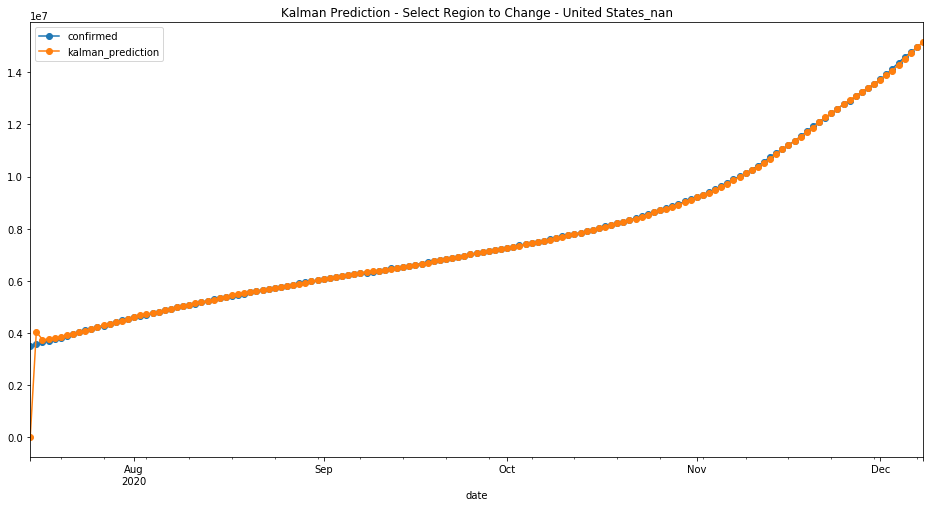

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
211  Russia_nan  4.268277e+10  206598.085134  19383.287671


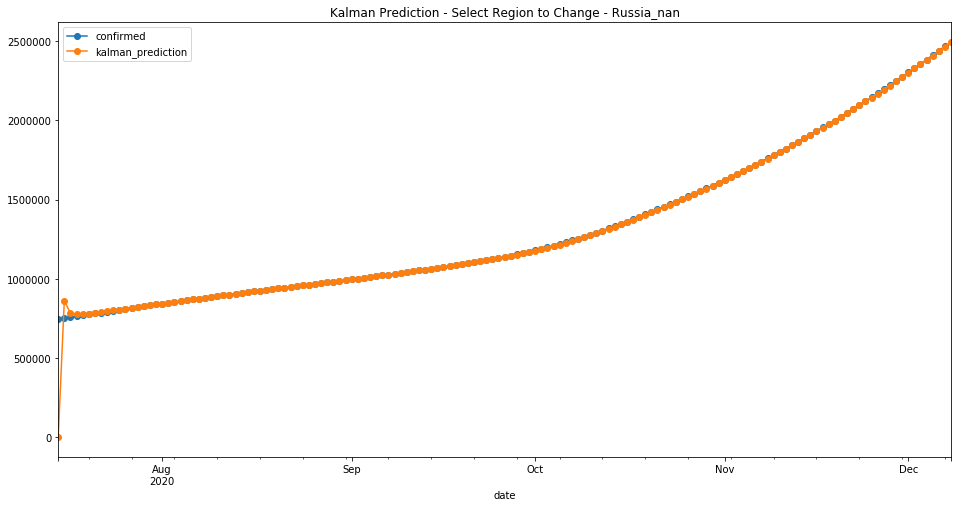

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  3.063665e+11  553503.812425  62832.739726


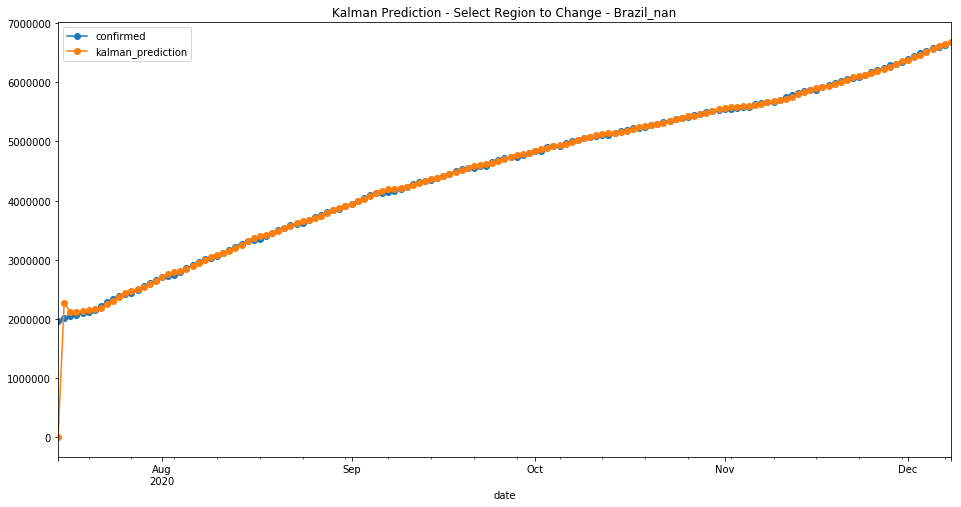

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
260  United Kingdom_nan  2.107465e+10  145171.111559  14688.910959


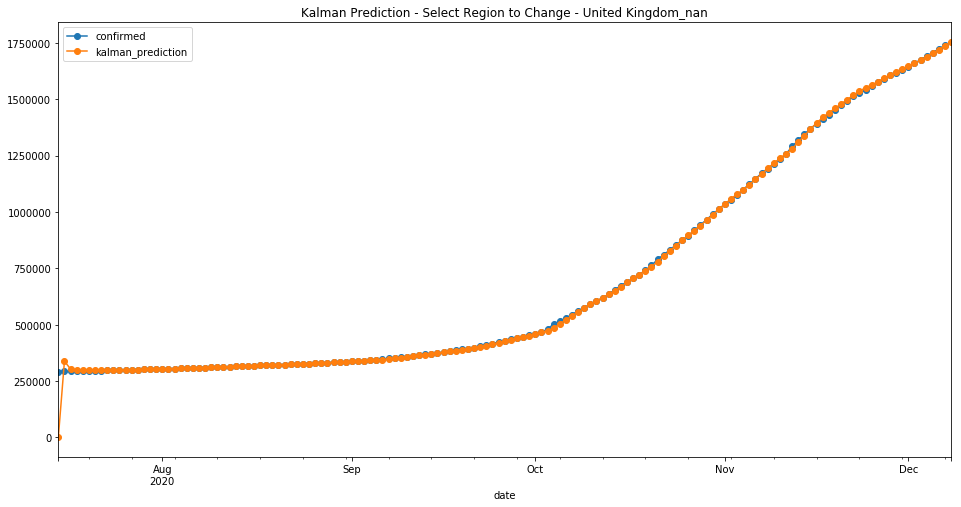

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbrdy4ztp
  JVM stdout: /tmp/tmpbrdy4ztp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbrdy4ztp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    2 months and 9 days
H2O_cluster_name:           H2O_from_python_unknownUser_m7uw3z
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-11-26
last_train_date= 2020-12-07
first_bootstrap_date= 2020-11-29
boost_bootstrap_date= 2020-12-04
first_test_date= 2020-11-28
last_test_date= 2020-12-08
first_valid_date= 2020-12-06


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   46099.0      46116 2020-11-29  Afghanistan_nan
1   46329.0      46274 2020-11-30  Afghanistan_nan
2   46487.0      46516 2020-12-01  Afghanistan_nan
3   46722.0      46718 2020-12-02  Afghanistan_nan
4   46925.0      46837 2020-12-03  Afghanistan_nan
5   47068.0      46837 2020-12-04  Afghanistan_nan
6   47089.0      47072 2020-12-05  Afghanistan_nan
7   47276.0      47306 2020-12-06  Afghanistan_nan
8   47475.0      47516 2020-12-07  Afghanistan_nan
9   47687.0          0 2020-12-08  Afghanistan_nan
10  37480.0      37625 2020-11-29      Albania_nan
11  38230.0      38182 2020-11-30      Albania_nan
12  38811.0      39014 2020-12-01      Albania_nan
13  39603.0      39719 2020-12-02      Albania_nan
14  40315.0      40501 2020-12-03      Albania_nan
15  41111.0      41302 2020-12-04      Albania_nan
16  41922.0      42148 2020-12-05      Albania_nan
17  42785.0      42988 2020-12-06      Albania_nan
18  43656.0      43683 2020-12-07      Albania_nan
19  44408.0          0 2020-12-08      Albania_nan
20  82351.0      82221 2020-11-29      Algeria_nan
21  83362.0      83199 2020-11-30      Algeria_nan
22  84335.0      84152 2020-12-01      Algeria_nan
23  85279.0      85084 2020-12-02      Algeria_nan
24  86191.0      85927 2020-12-03      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  137862.0     138000 2020-12-04  Azerbaijan_nan
176  142180.0     142323 2020-12-05  Azerbaijan_nan
177  146588.0     146679 2020-12-06  Azerbaijan_nan
178  151034.0     149765 2020-12-07  Azerbaijan_nan
179  154201.0          0 2020-12-08  Azerbaijan_nan
180    7581.0       7517 2020-11-29     Bahamas_nan
181    7573.0       7541 2020-11-30     Bahamas_nan
182    7590.0       7543 2020-12-01     Bahamas_nan
183    7620.0       7543 2020-12-02     Bahamas_nan
184    7623.0       7549 2020-12-03     Bahamas_nan
185    7617.0       7565 2020-12-04     Bahamas_nan
186    7619.0       7570 2020-12-05     Bahamas_nan
187    7637.0       7570 2020-12-06     Bahamas_nan
188    7643.0       7579 2020-12-07     Bahamas_nan
189    7638.0          0 2020-12-08     Bahamas_nan
190   86467.0      86787 2020-11-29     Bahrain_nan
191   86613.0      86956 2020-11-30     Bahrain_nan
192   86779.0      87137 2020-12-01     Bahrain_nan
193   86956.0      87270 2020-12-02     Bahrain_nan
194   87093.0      87432 2020-12-03     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  134872.0     135008 2020-11-29  Belarus_nan
221  136580.0     136647 2020-11-30  Belarus_nan
222  138255.0     138219 2020-12-01  Belarus_nan
223  139862.0     139908 2020-12-02  Belarus_nan
224  141571.0     141609 2020-12-03  Belarus_nan
225  143272.0     143383 2020-12-04  Belarus_nan
226  145056.0     145279 2020-12-05  Belarus_nan
227  146964.0     147157 2020-12-06  Belarus_nan
228  148869.0     148953 2020-12-07  Belarus_nan
229  150715.0          0 2020-12-08  Belarus_nan
230  576392.0     576599 2020-11-29  Belgium_nan
231  578644.0     577345 2020-11-30  Belgium_nan
232  579606.0     579212 2020-12-01  Belgium_nan
233  581535.0     582252 2020-12-02  Belgium_nan
234  584327.0     584857 2020-12-03  Belgium_nan
235  586658.0     587439 2020-12-04  Belgium_nan
236  589225.0     589942 2020-12-05  Belgium_nan
237  591805.0     591756 2020-12-06  Belgium_nan
238  593690.0     592615 2020-12-07  Belgium_nan
239  594579.0          0 2020-12-08  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2128132024.7443357
# MSE on the validation data =  3151922636726.177
# R^2 on the training data =  0.9994137529000878
# R^2 on the validation data =  0.48384624360102446


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1607408287585_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           19109002.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0      22.982      2757.0      3086.0      2988.41



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2128132024.7443357
RMSE: 46131.68135613893
MAE: 4967.278982230243
RMSLE: 0.20943675803979922
Mean Residual Deviance: 2128132024.7443357

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 3151922636726.177
RMSE: 1775365.493842374
MAE: 457528.77583749726
RMSLE: 7.200048976959776
Mean Residual Deviance: 3151922636726.177

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-12-08 06:18:16   0.119 sec              0.0            NaN   
1     2020-12-08 06:18:17   0.569 sec              1.0   52036.585912   
2     2020-12-08 06:18:17   0.768 sec              2.0   48997.725959   
3     2020-12-08 06:18:17   0.901 sec              3.0   81734.560759   
4     2020-12-08 06:18:17   1.027 sec              4.0   73170.291166   
5     2020-12-08 06:18:17   1.149 sec              5.0   70246.652188   
6     2020-12-08 06:18:18   1.367 sec              6.0   77694.921229   
7     2020-12-08 06:18:18   1.469 sec              7.0   77693.205316   
8     2020-12-08 06:18:18   1.569 sec              8.0   75378.736709   
9     2020-12-08 06:18:18   1.650 sec              9.0   77516.129935   
10    2020-12-08 06:18:18   1.718 sec             10.0   70587.293983   
11    2020-12-08 06:18:18   1.795 sec             11.0   63931.414174   
12    2020-12-08 06:18:18   1.883 sec             12.0   65498.651898   
13    2020-12-08 06:18:18   1.979 sec             13.0   65767.561059   
14    2020-12-08 06:18:18   2.076 sec             14.0   66772.381586   
15    2020-12-08 06:18:18   2.177 sec             15.0   66490.199258   
16    2020-12-08 06:18:18   2.275 sec             16.0   65908.914552   
17    2020-12-08 06:18:19   2.353 sec             17.0   64128.676387   
18    2020-12-08 06:18:19   2.422 sec             18.0   64151.478077   
19    2020-12-08 06:18:19   2.493 sec             19.0   63983.157726   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   10905.531965       2.707806e+09     1.861225e+06   468866.470228   
2   10949.004324       2.400777e+09     1.846722e+06   468408.082559   
3   13380.982819       6.680538e+09     1.798766e+06   457357.279514   
4   12312.501368       5.353892e+09     1.812315e+06   459418.720662   
5   11936.121043       4.934592e+09     1.819931e+06   459830.646849   
6   12034.548936       6.036501e+09     1.821160e+06   461324.091453   
7   11779.206010       6.036234e+09     1.826773e+06   462559.692577   
8   10885.188347       5.681954e+09     1.820764e+06   462139.010381   
9   11199.788230       6.008750e+09     1.819068e+06   462738.249885   
10  10468.788829       4.982566e+09     1.819481e+06   463073.178354   
11   9831.125613       4.087226e+09     1.821997e+06   463335.757228   
12   9907.564179       4.290073e+09     1.823548e+06   463564.649181   
13   9888.916783       4.325372e+09     1.809560e+06   463314.370399   
14   9855.494107       4.458551e+09     1.803627e+06   463917.523687   
15   9596.901735       4.420947e+09     1.805121e+06   464045.027116   
16   9448.749551       4.343985e+09     1.807960e+06   463764.992220   
17   9149.540700       4.112487e+09     1.793685e+06   460946.110166   
18   9074.955973       4.115412e+09     1.797165e+06   461788.723215   
19   8973.101870       4.093844e+09     1.784572e+06   460501.370347   

    validation_deviance  
0                   NaN  
1          3.464159e+12  
2          3.410381e+12  
3          3.235557e+12  
4          3.284485e+12  
5          3.312147e+12  
6          3.316624e+12  
7          3.337101e+12  
8          3.315181e+12  
9          3.309009e+12  
10         3.310511e+12  
11         3.319673e+12  
12         3.325328e+12  
13         3.274506e+12  
14         3.253069e+12  
15         3.258463e+12  
16         3.268720e+12  
17         3.217306e+12  
18         3.229802e+12  
19         3.184698e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0            last_day         3.263224e+18           1.000000    0.338237
1   kalman_prediction         2.593827e+18           0.794866    0.268853
2              region         1.404354e+18           0.430358    0.145563
3        7_day_change         1.152583e+18           0.353204    0.119467
4        3_day_change         6.560993e+17           0.201059    0.068006
5        1_day_change         3.576599e+17           0.109603    0.037072
6       infected_rate         1.065642e+17           0.032656    0.011046
7   7_day_change_rate         4.530544e+16           0.013884    0.004696
8   3_day_change_rate         3.277575e+16           0.010044    0.003397
9   1_day_change_rate         1.574659e+16           0.004825    0.001632
10                max         1.104800e+16           0.003386    0.001145
11                min         8.549721e+15           0.002620    0.000886

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0            last_day         3.263224e+18           1.000000    0.338237
1   kalman_prediction         2.593827e+18           0.794866    0.268853
2              region         1.404354e+18           0.430358    0.145563
3        7_day_change         1.152583e+18           0.353204    0.119467
4        3_day_change         6.560993e+17           0.201059    0.068006
5        1_day_change         3.576599e+17           0.109603    0.037072
6       infected_rate         1.065642e+17           0.032656    0.011046
7   7_day_change_rate         4.530544e+16           0.013884    0.004696
8   3_day_change_rate         3.277575e+16           0.010044    0.003397
9   1_day_change_rate         1.574659e+16           0.004825    0.001632
10                max         1.104800e+16           0.003386    0.001145
11                min         8.549721e+15           0.002620    0.000886

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


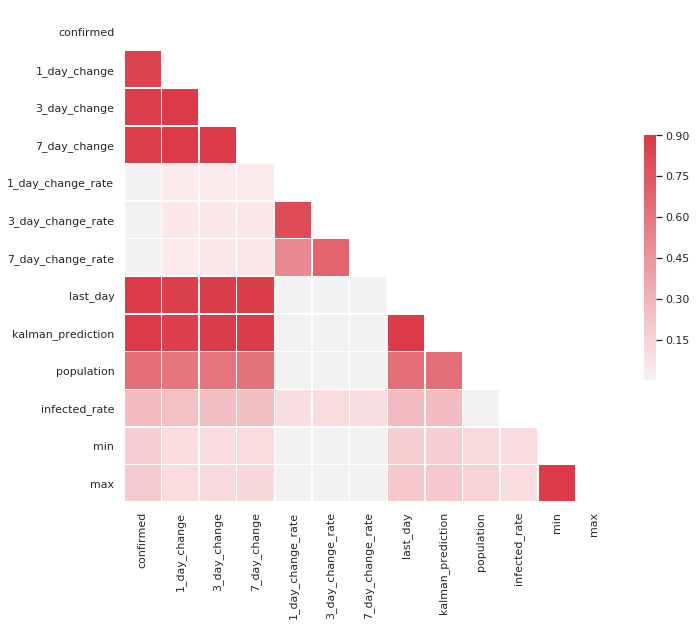

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.854350
3_day_change         0.869415
7_day_change         0.875305
1_day_change_rate    0.028628
3_day_change_rate    0.029233
7_day_change_rate    0.023462
last_day             0.988846
kalman_prediction    0.989321
population           0.642018
infected_rate        0.261063
min                  0.178994
max                  0.195154
Name: confirmed, dtype: float64


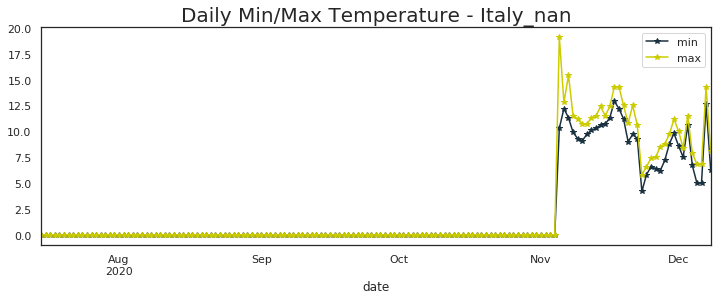

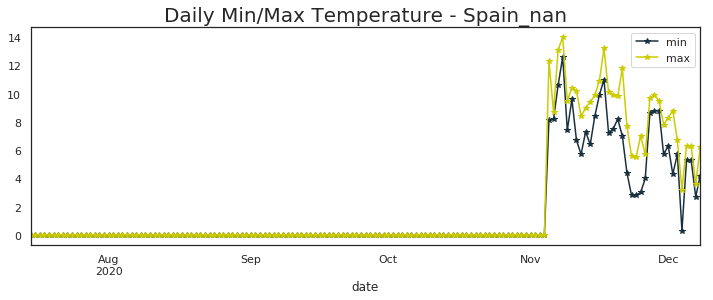

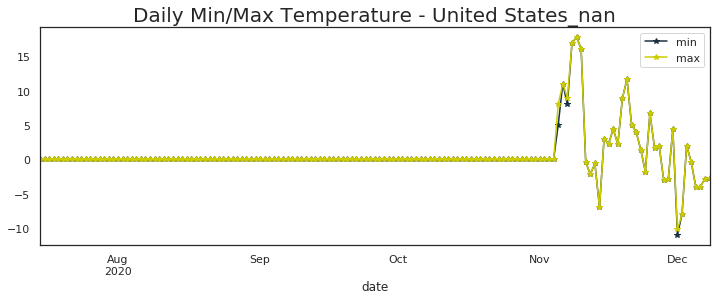

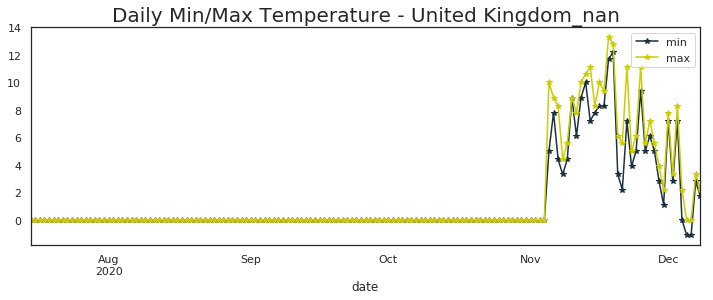

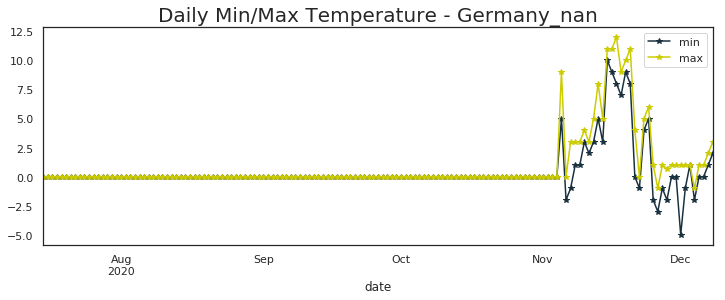

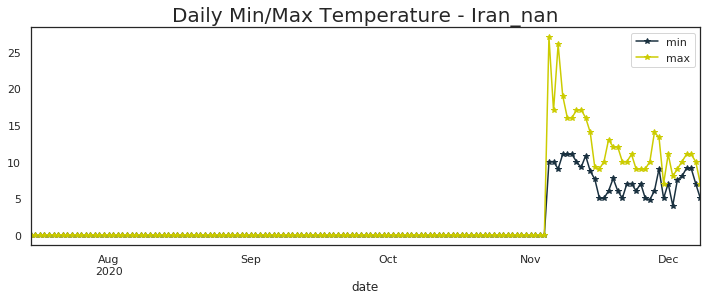

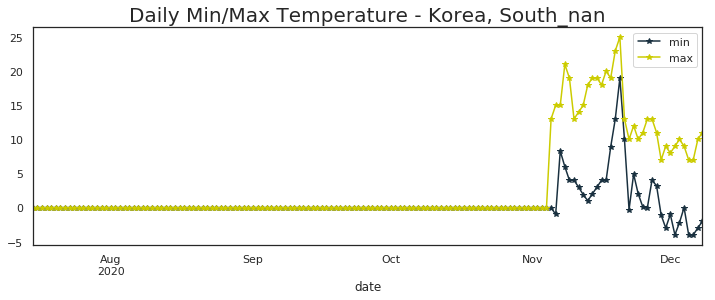

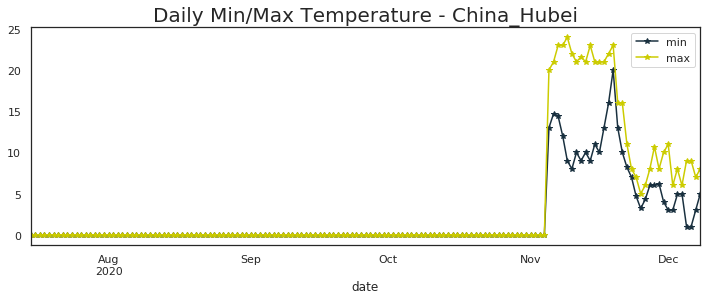

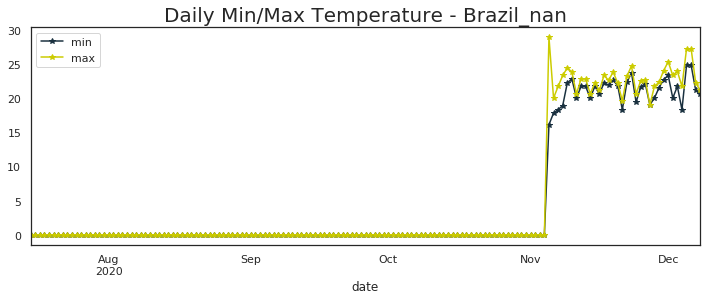

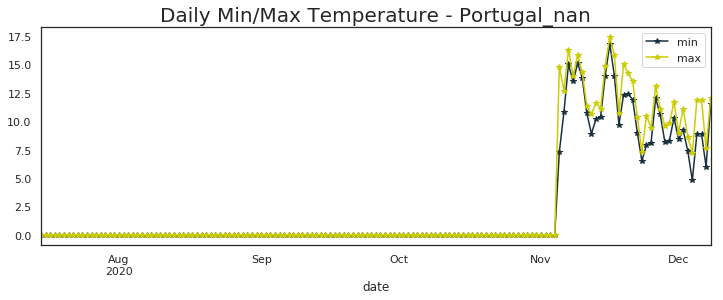

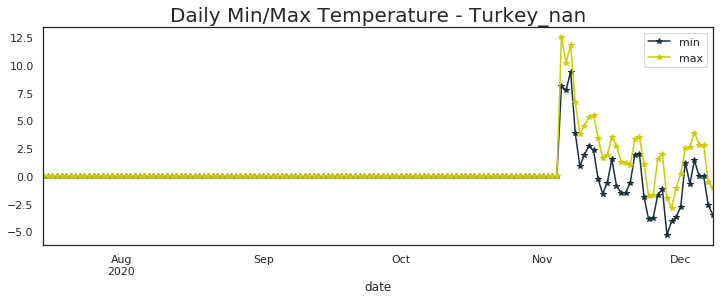

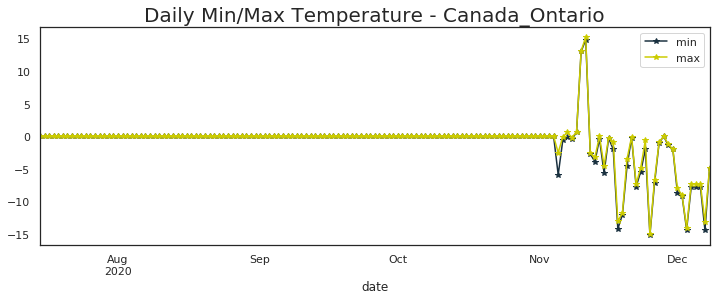

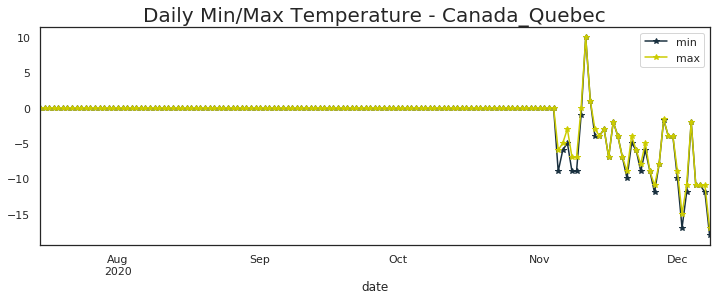

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   22.0  31.0
Brazil_nan                  24.8  28.9
Russia_nan                   0.0   4.0
France_nan                  12.1  13.3
Italy_nan                   12.9  19.1
United Kingdom_nan          12.2  13.3
Spain_nan                   12.6  14.0
Argentina_nan                0.0   0.0
Colombia_nan                 0.0   0.0
Germany_nan                 10.0  12.0
Mexico_nan                  15.1  15.1
Poland_nan                   8.9  10.6
Iran_nan                    11.0  27.0
Peru_nan                    24.6  29.9
Turkey_nan                   9.4  12.5
Ukraine_nan                  0.0   0.0
South Africa_nan             0.0   0.0
Belgium_nan                 13.7  14.5
Indonesia_nan                0.0   0.0
Iraq_nan                     0.0   0.0
Netherlands_nan             14.4  16.1
Chile_nan                   

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

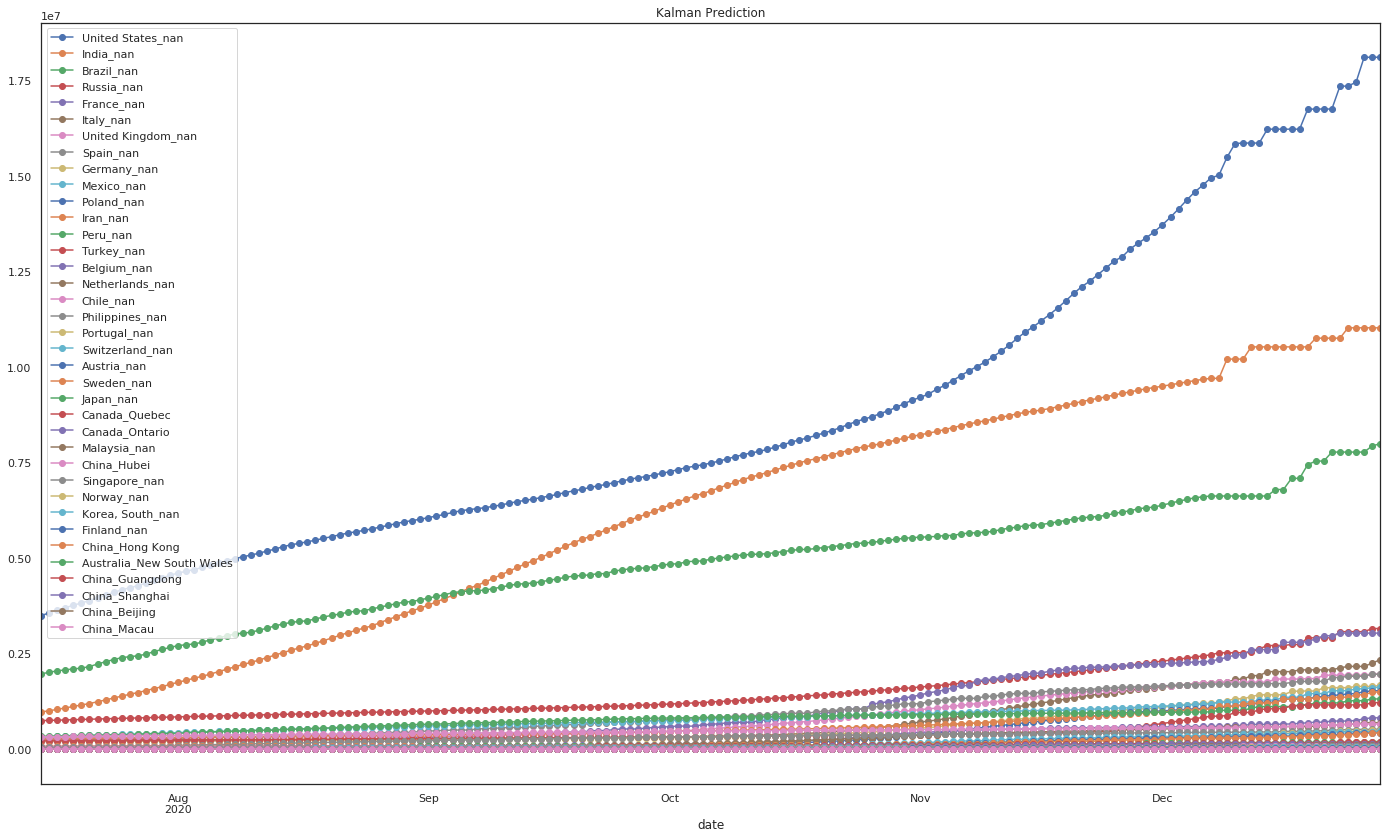

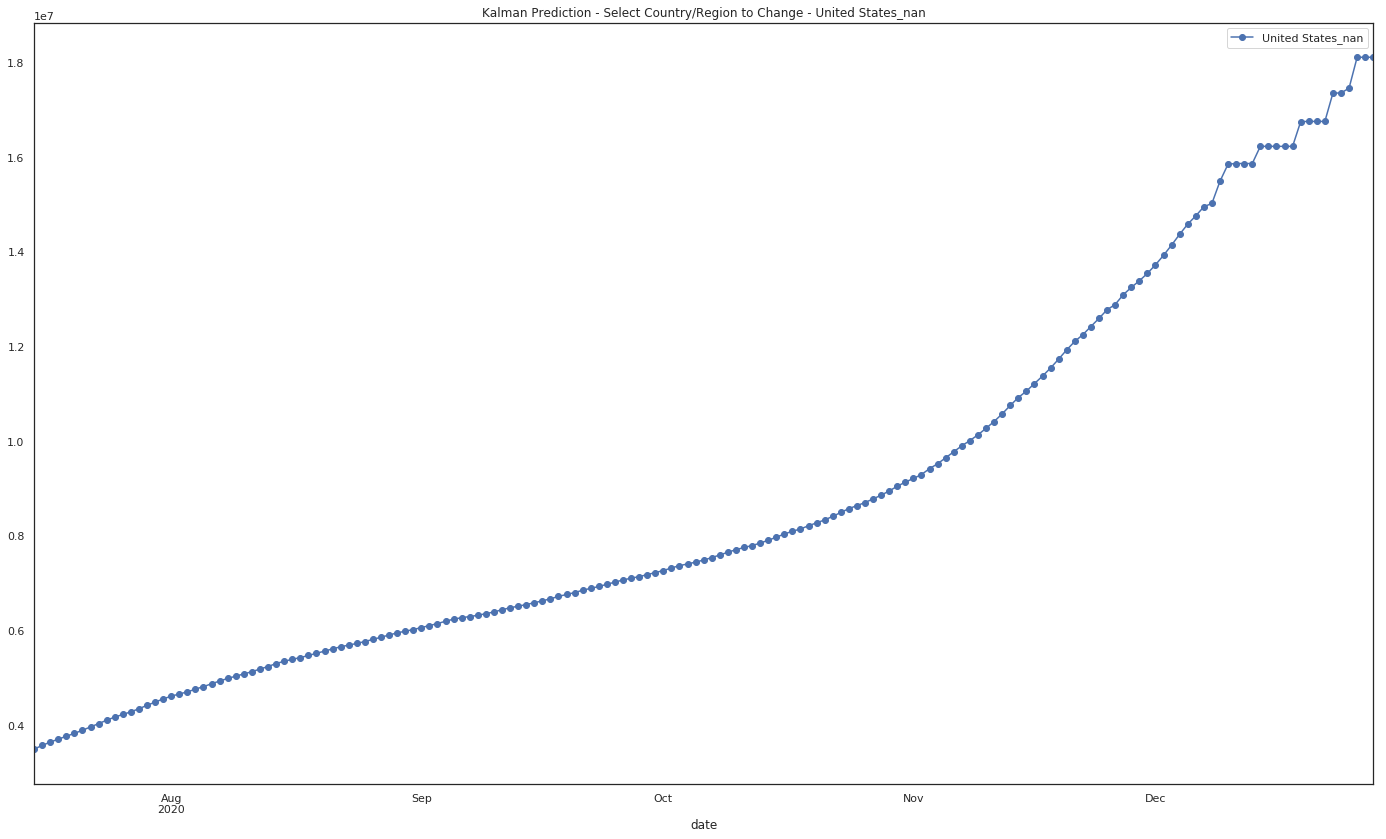

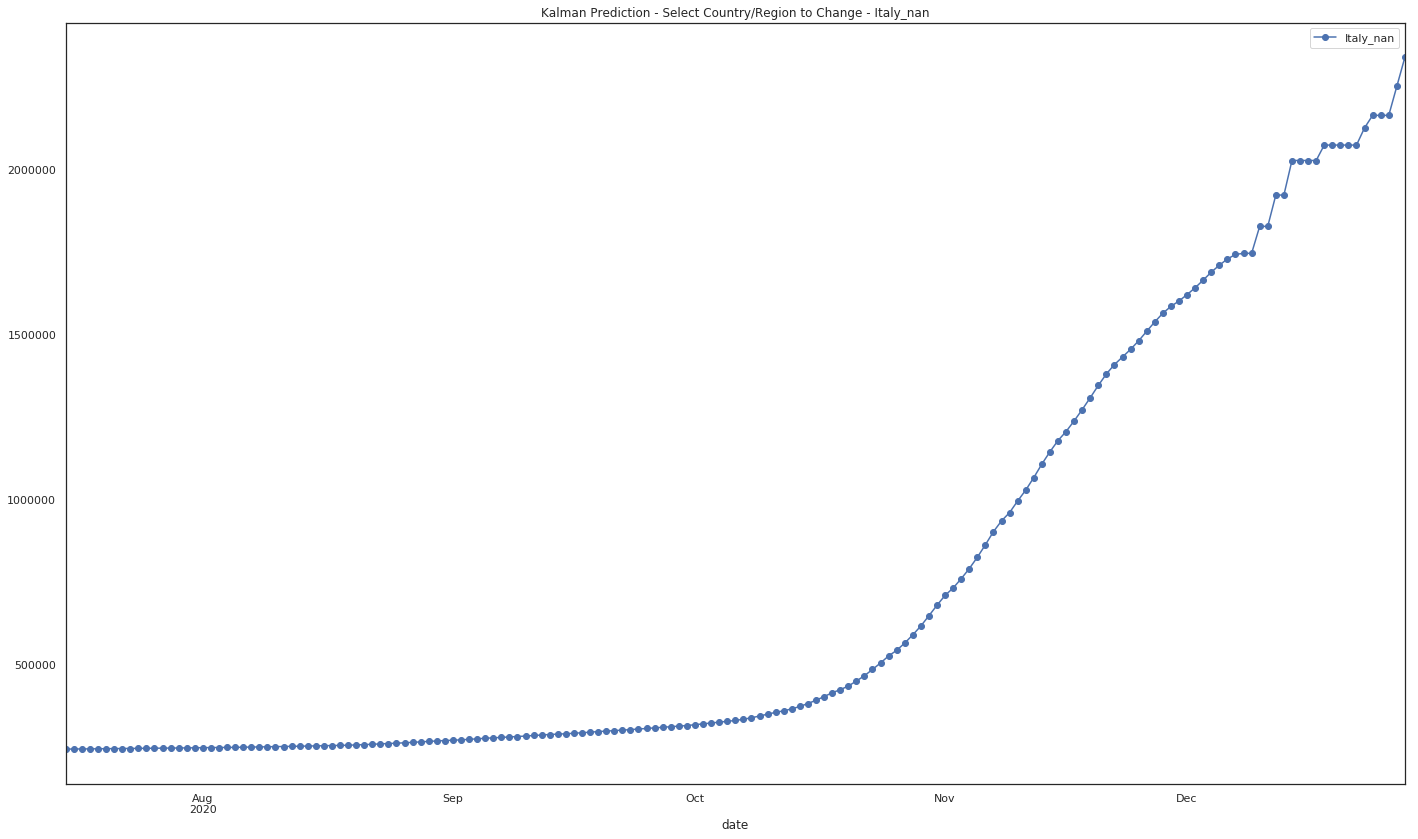

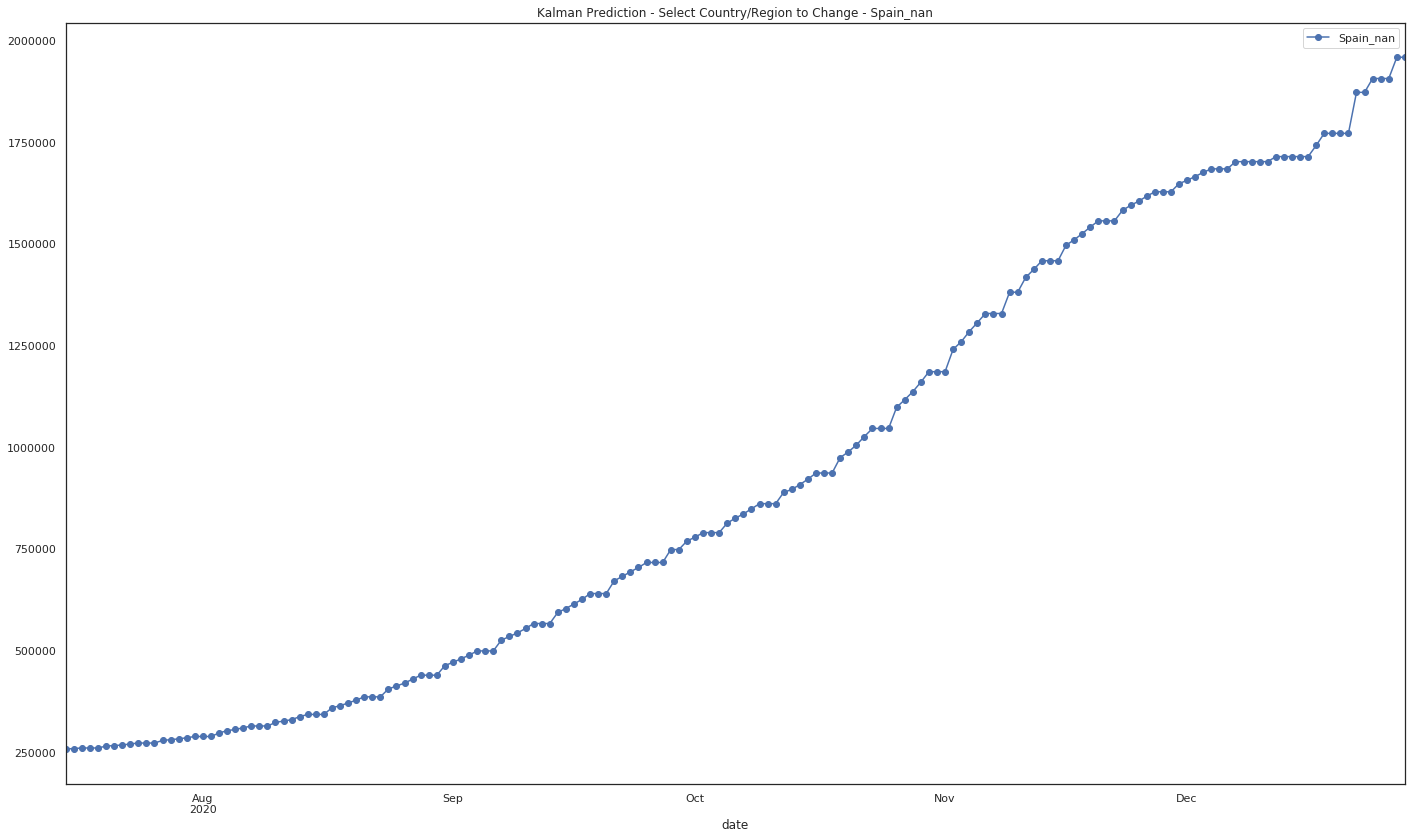

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


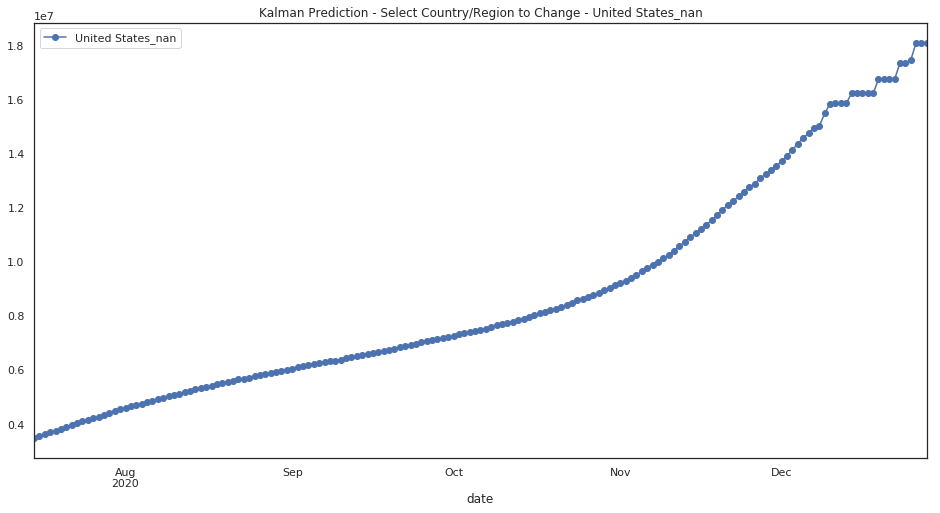

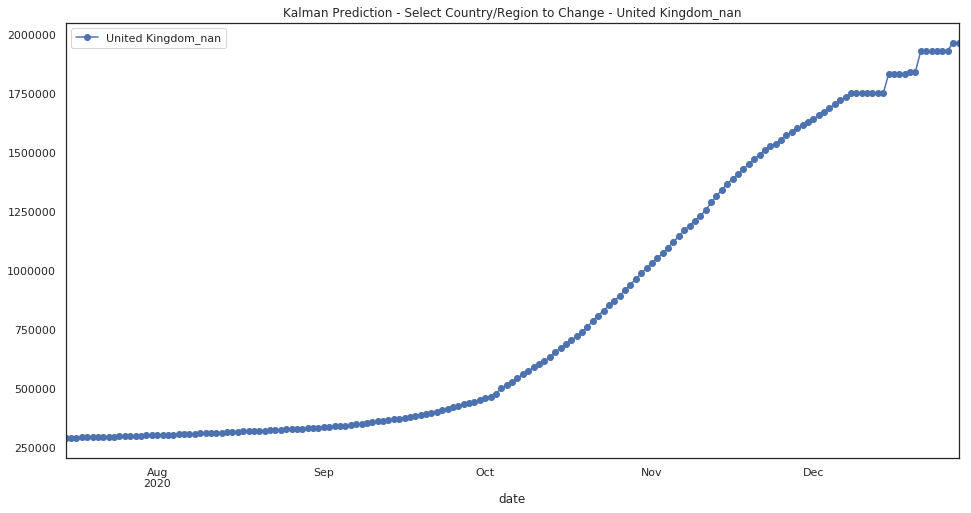

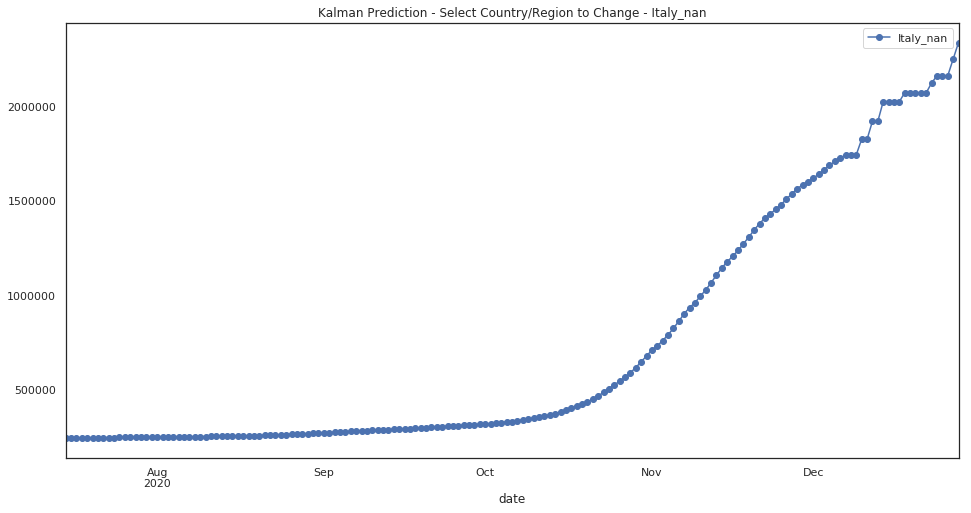

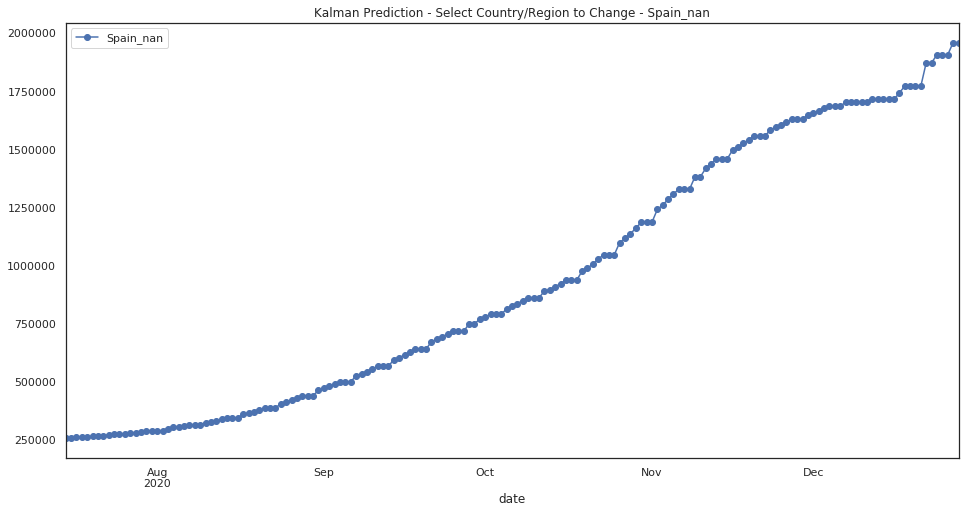

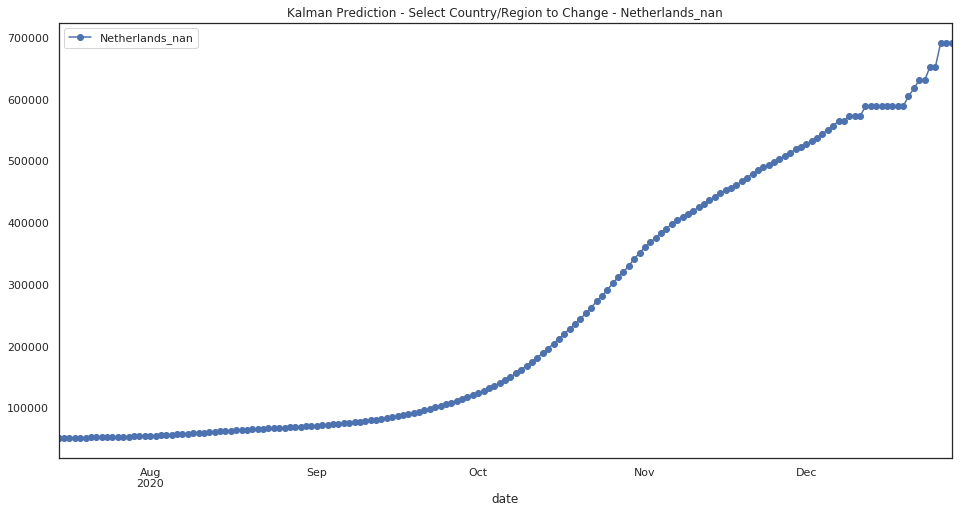

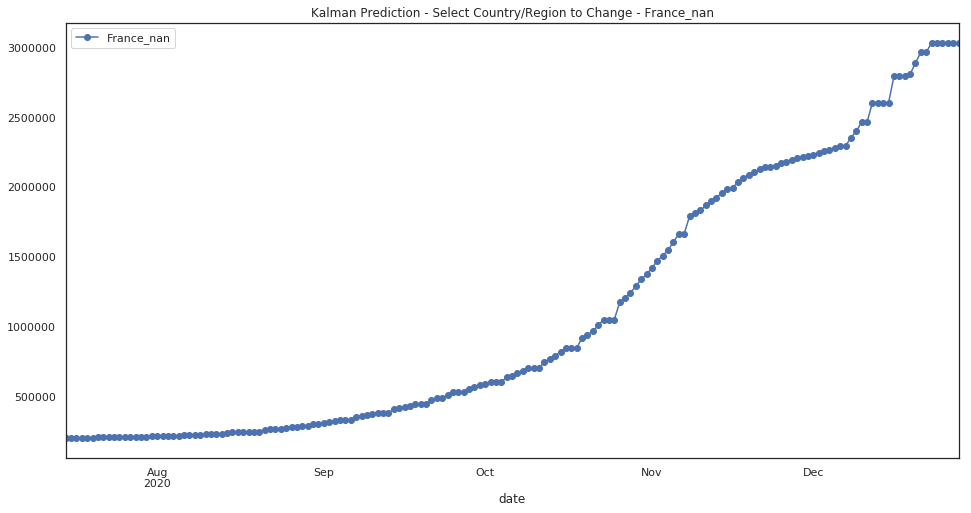

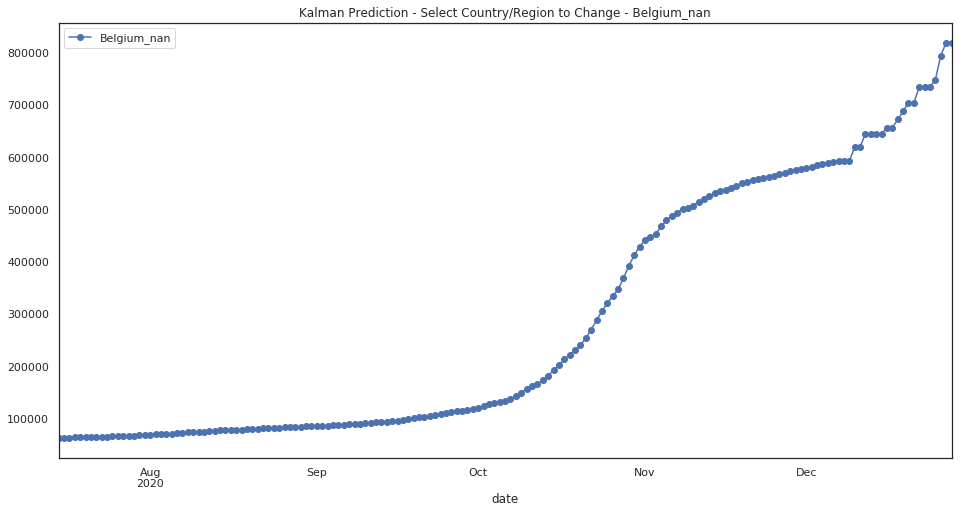

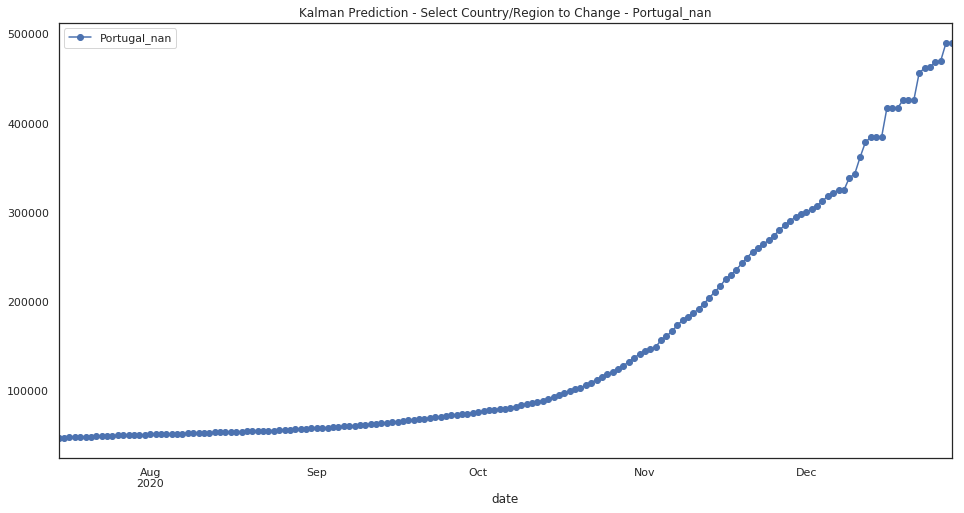

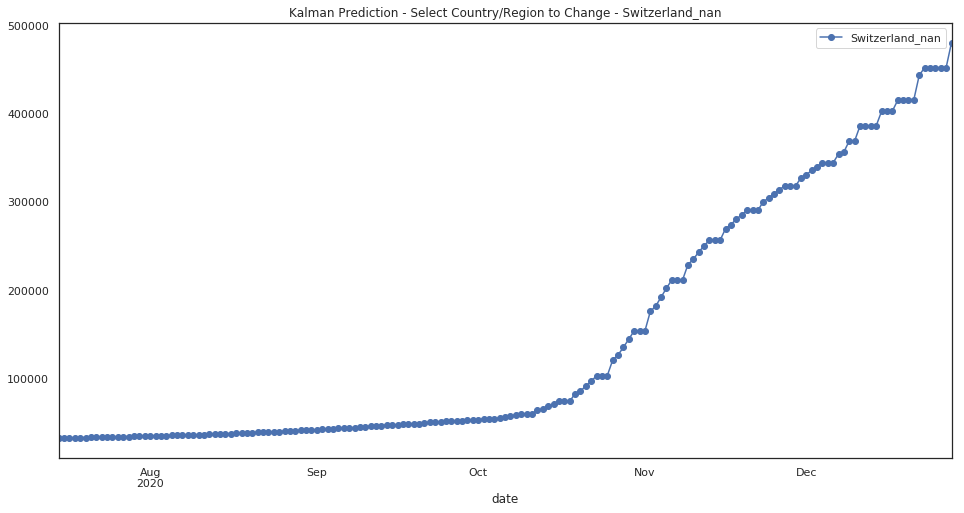

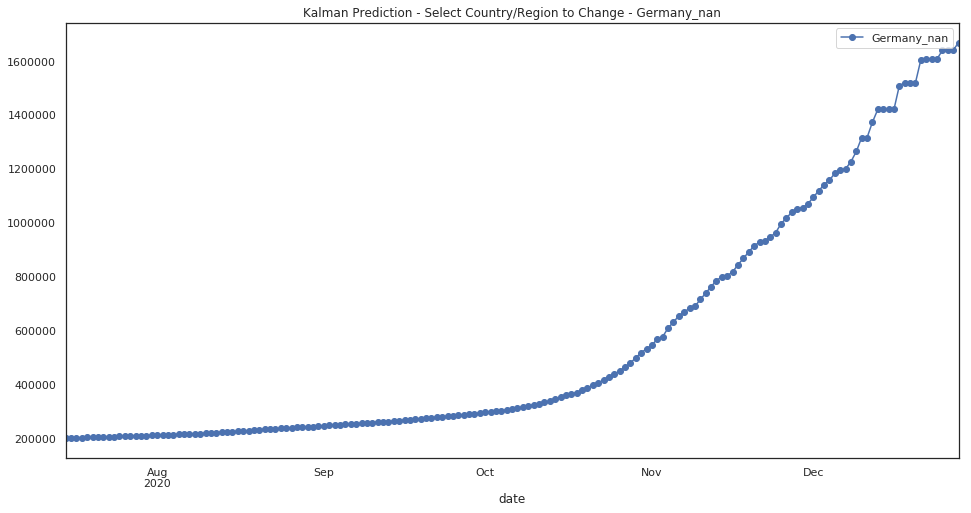

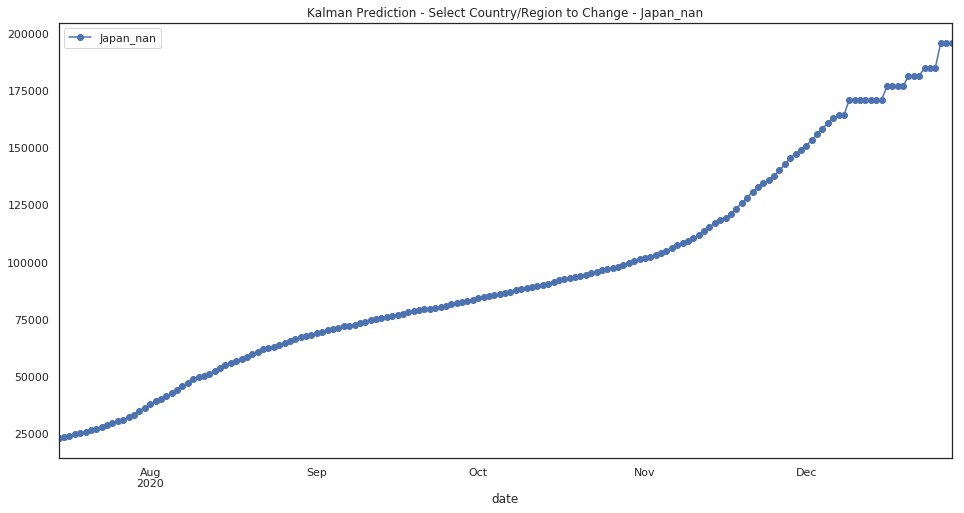

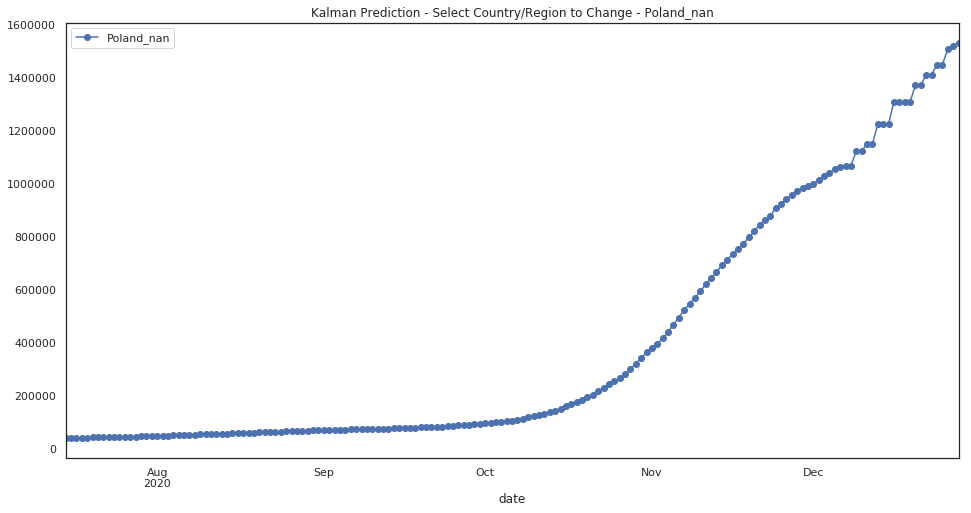

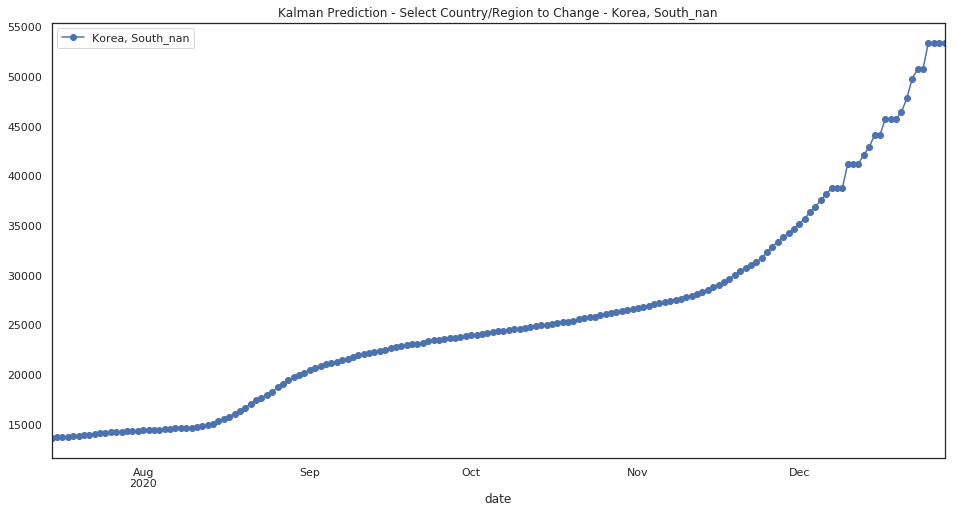

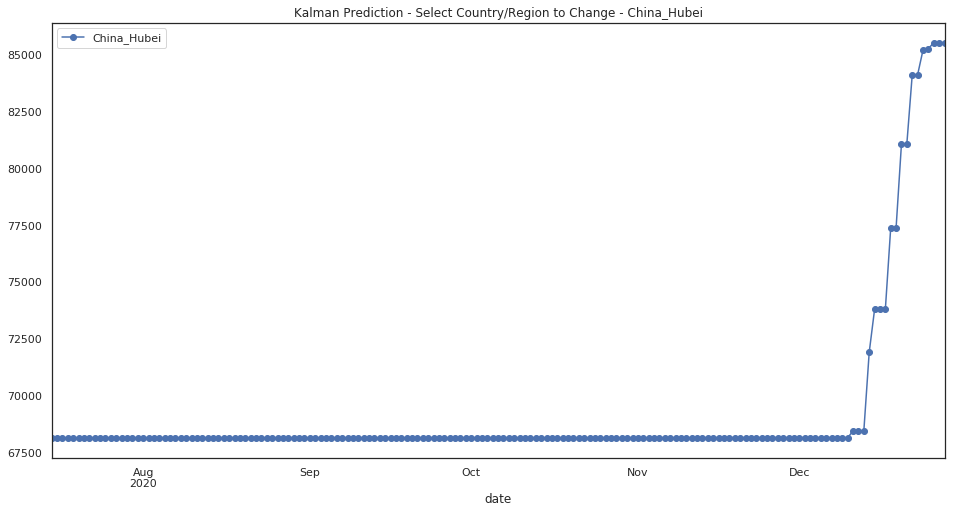

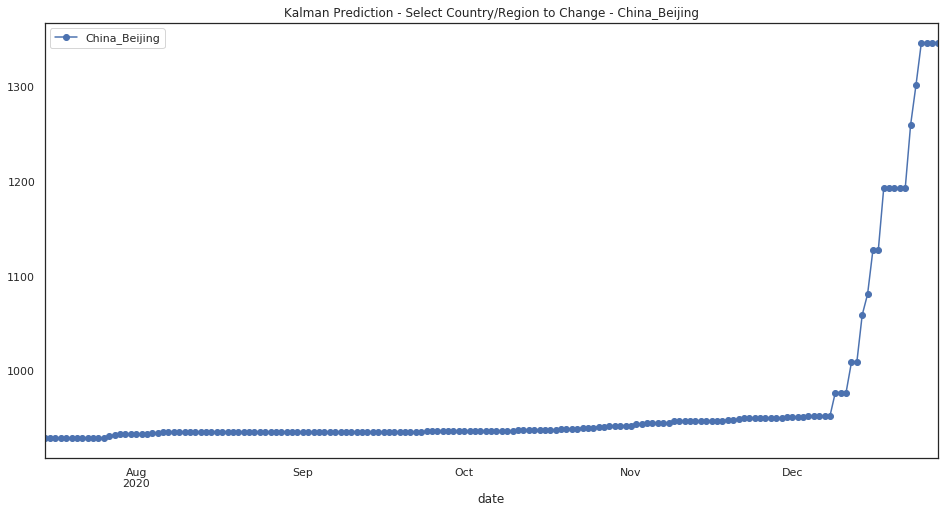

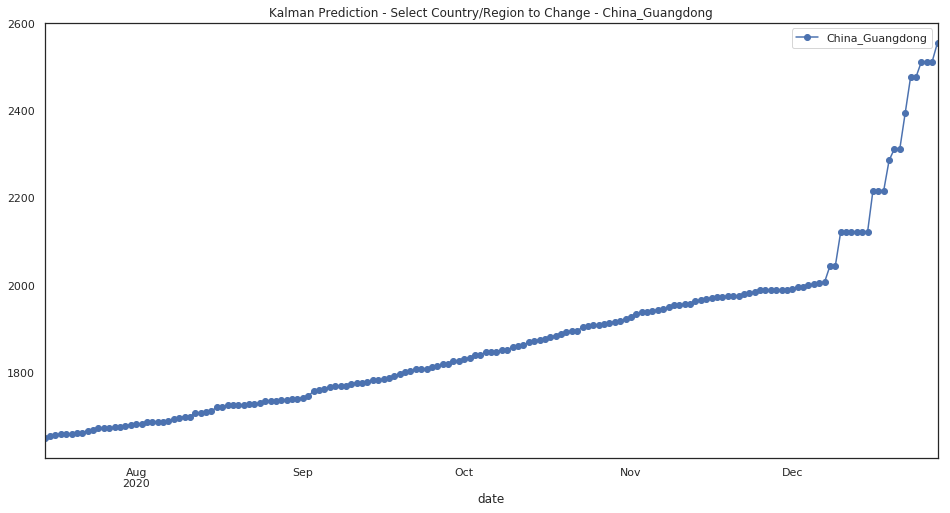

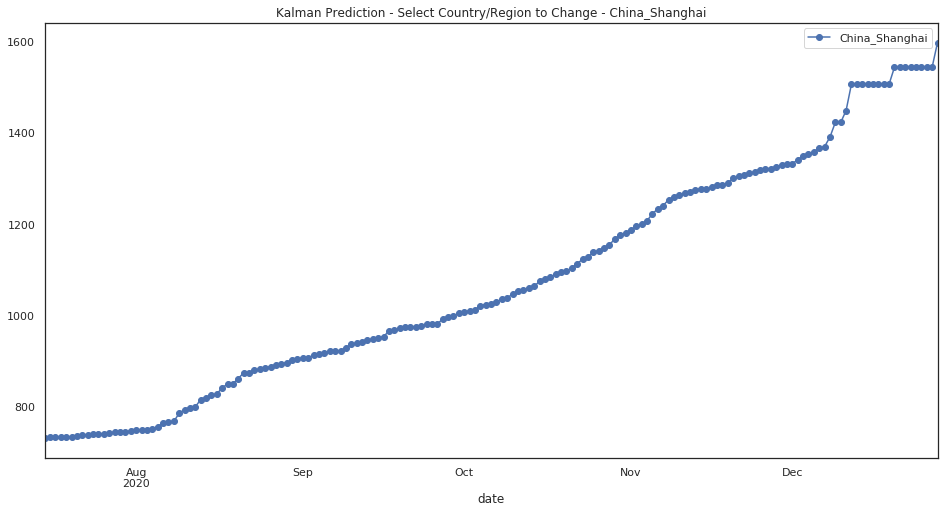

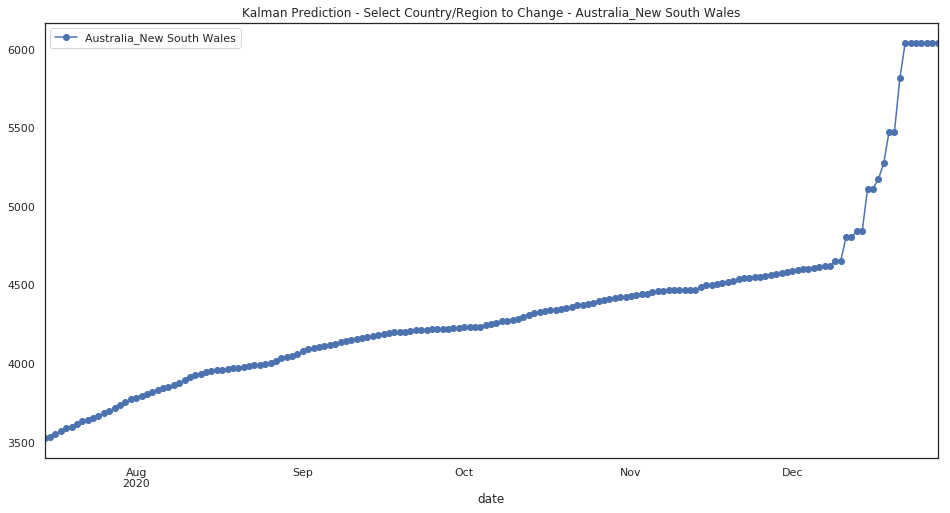

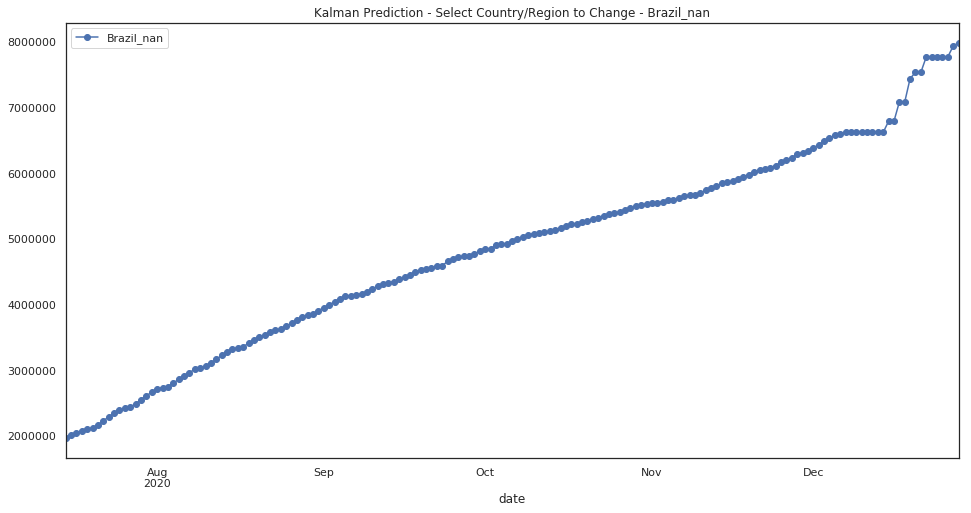

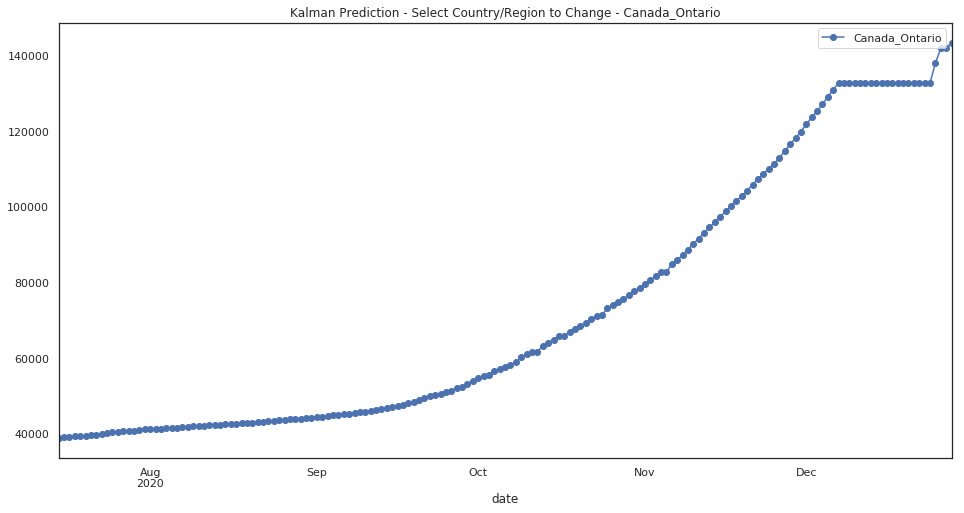

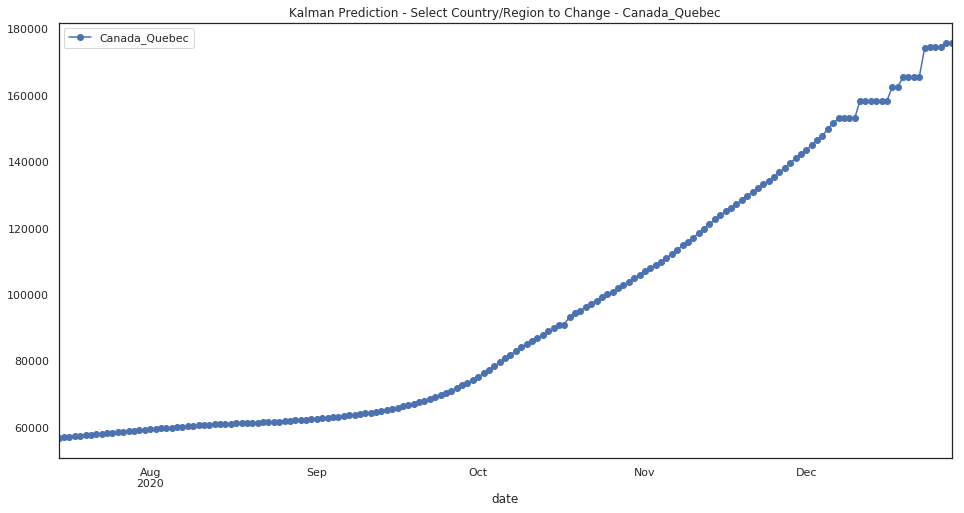

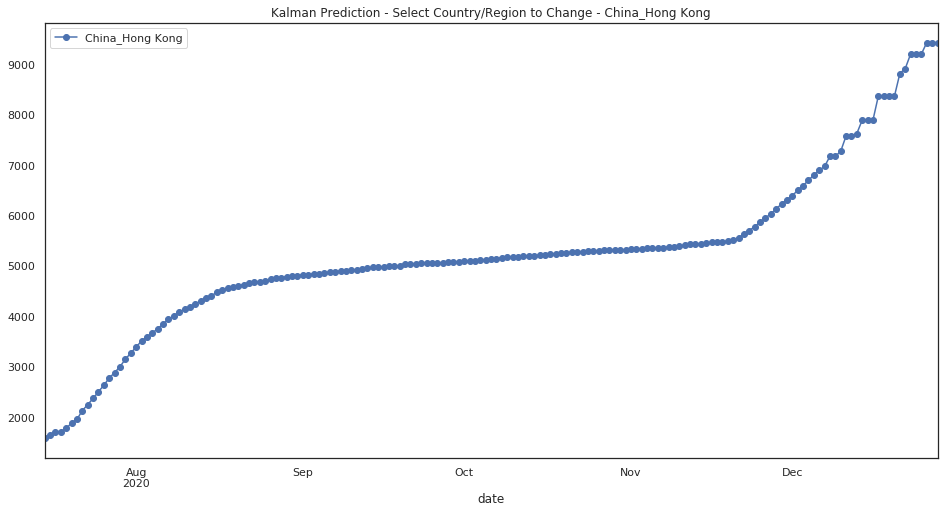

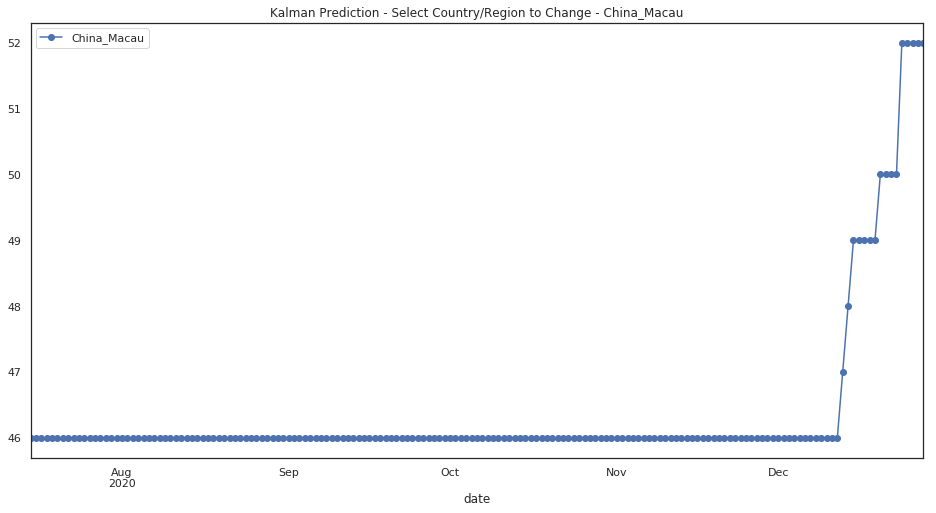

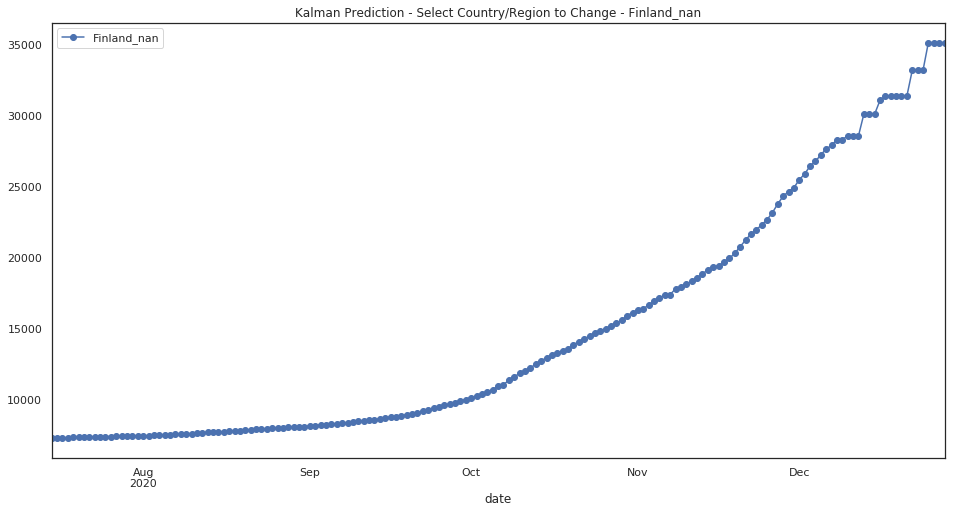

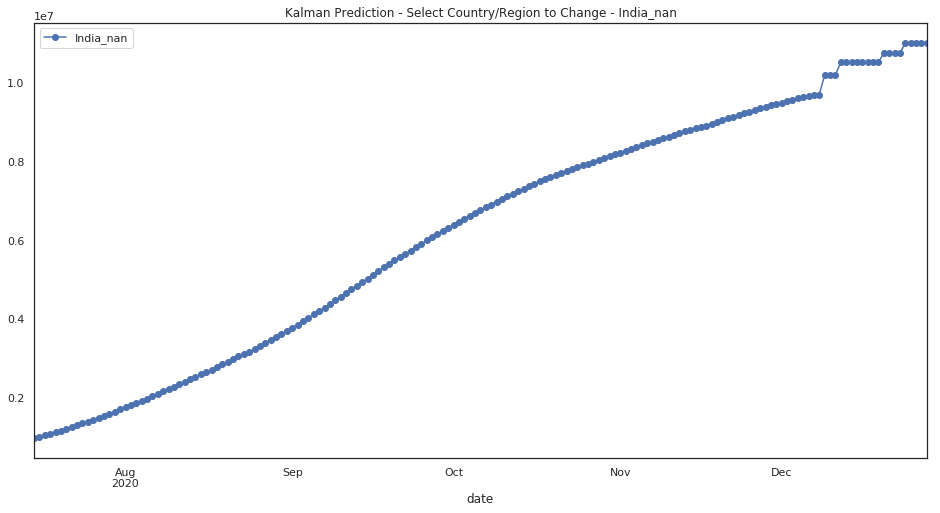

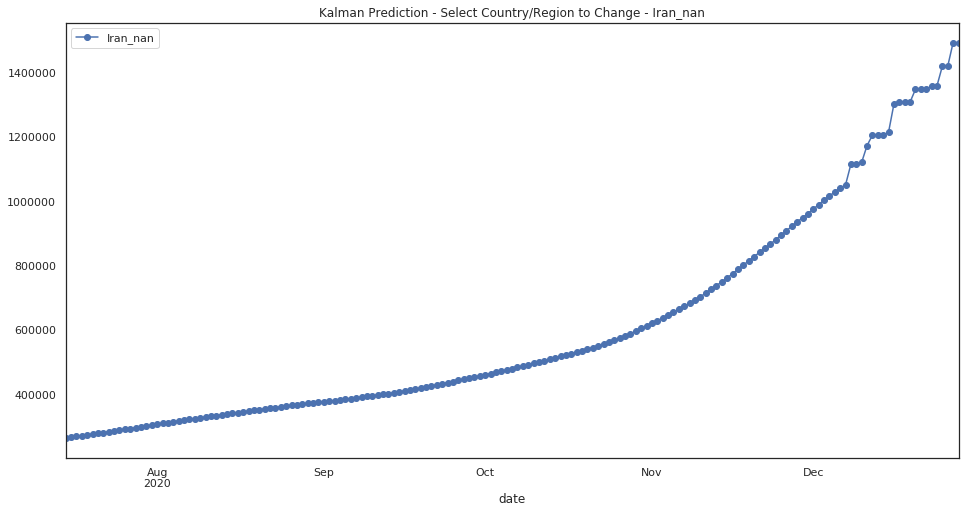

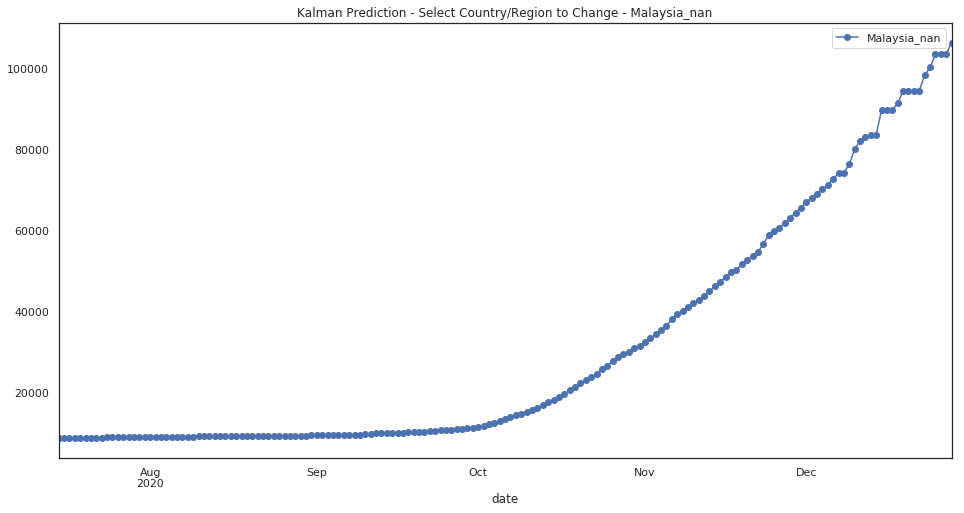

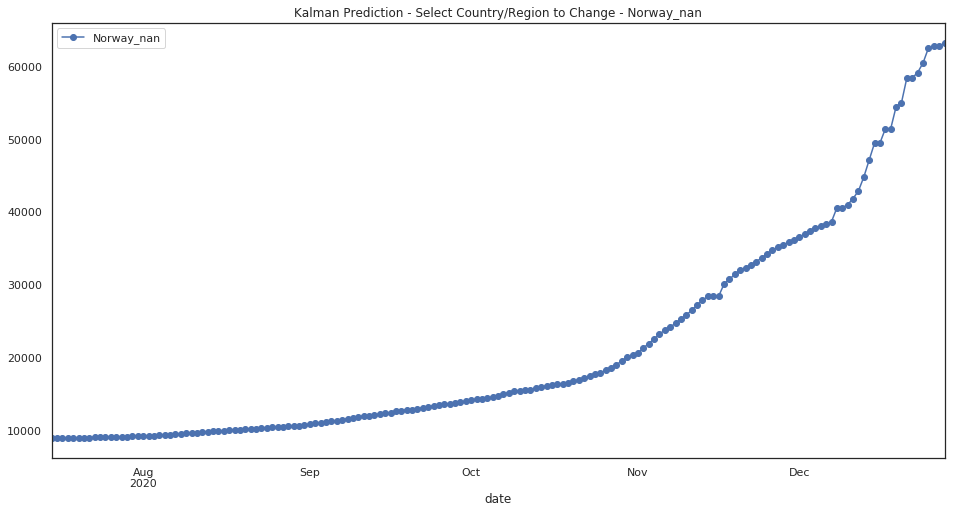

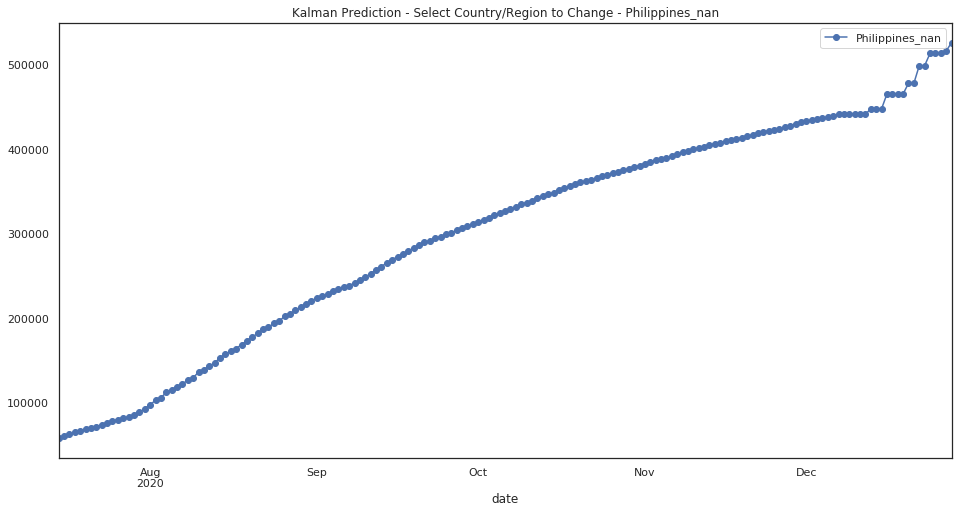

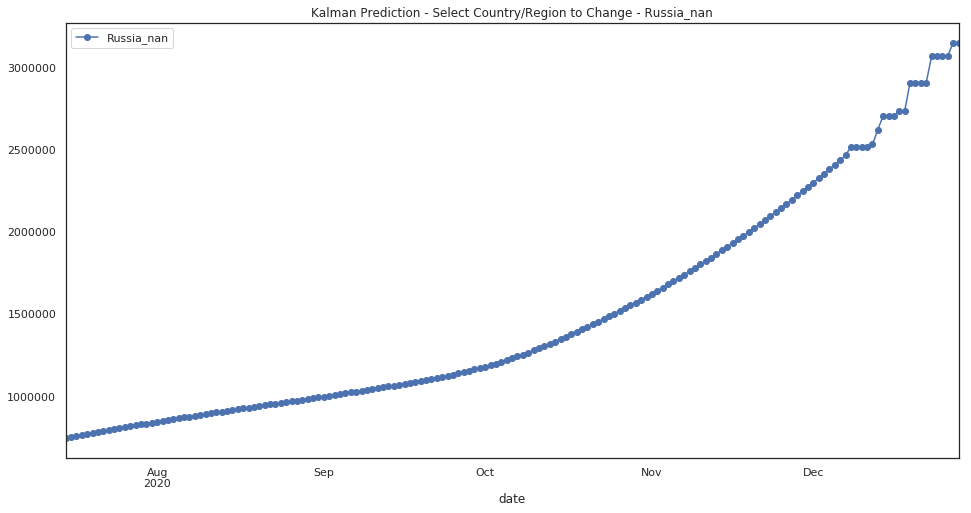

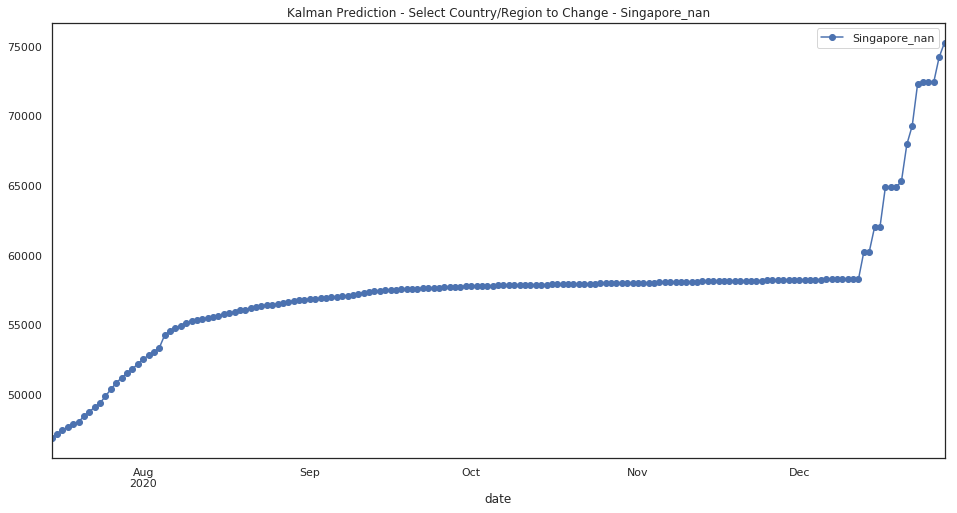

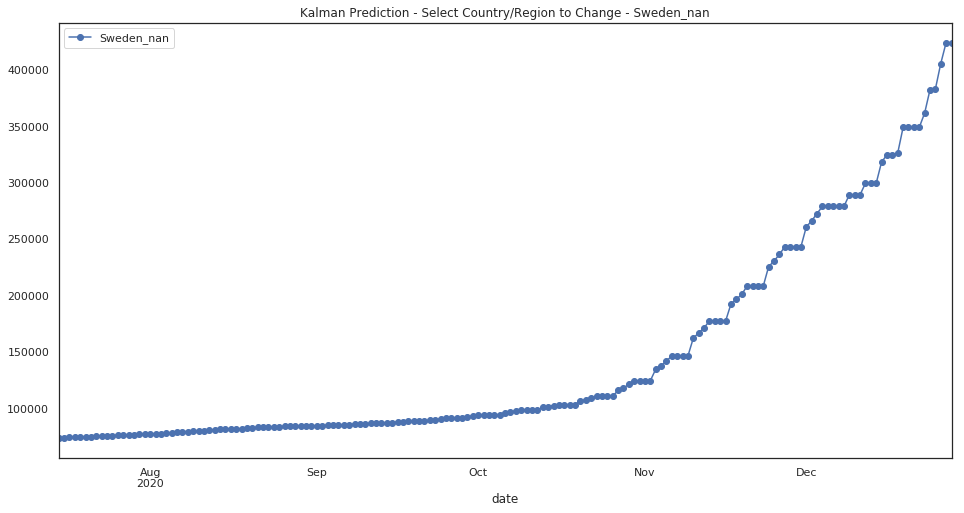

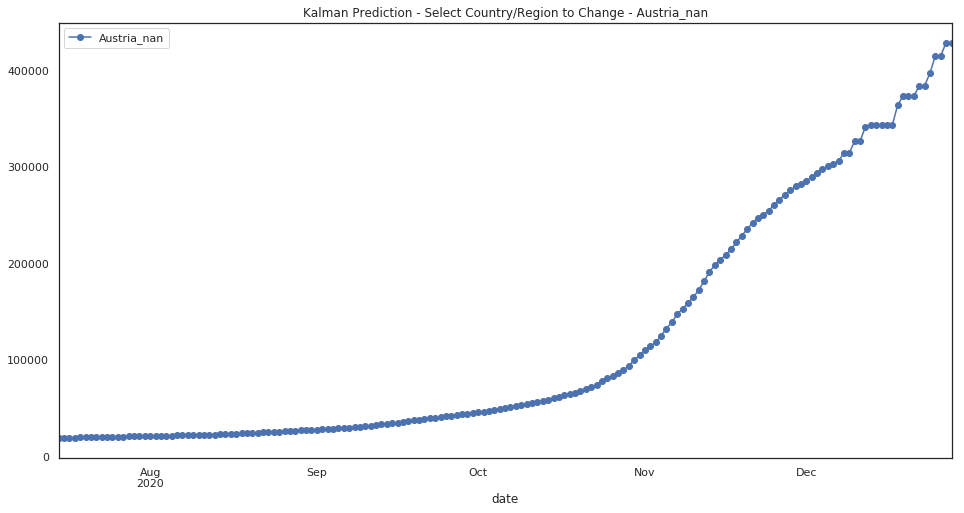

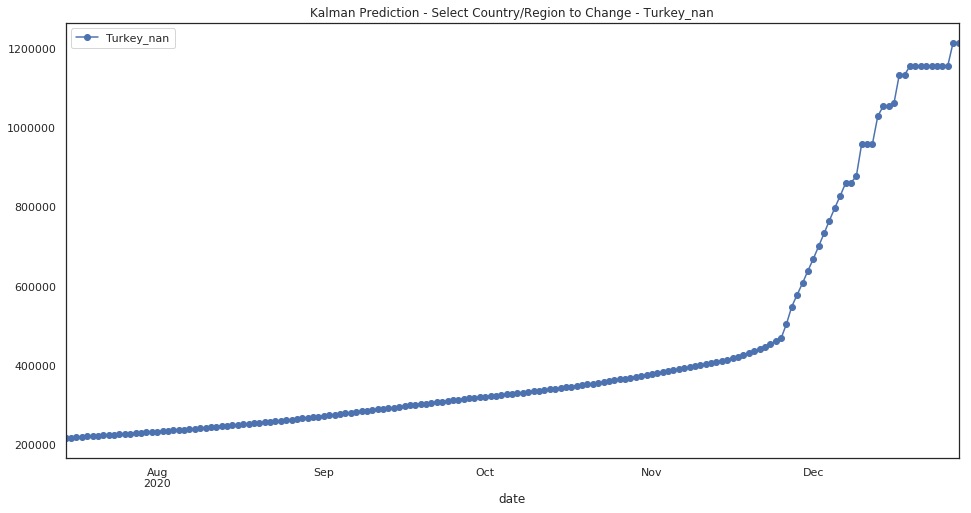

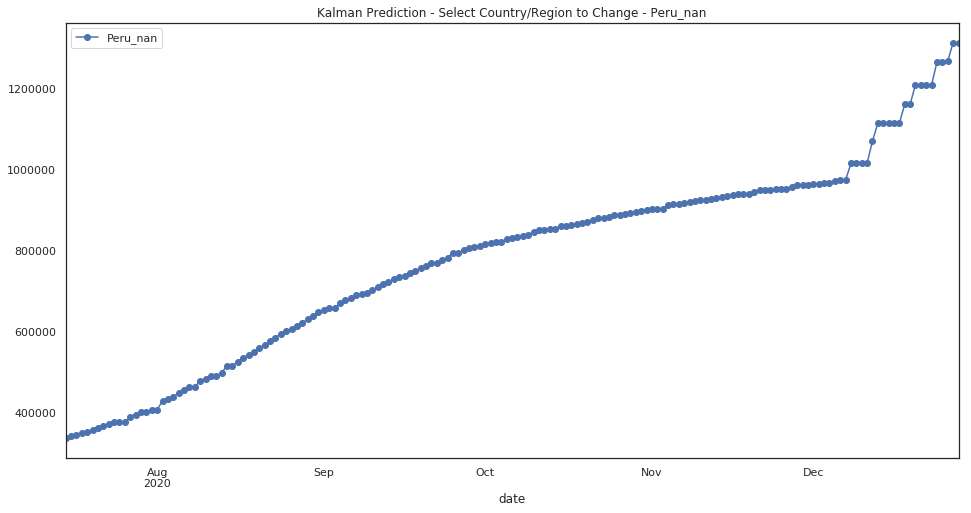

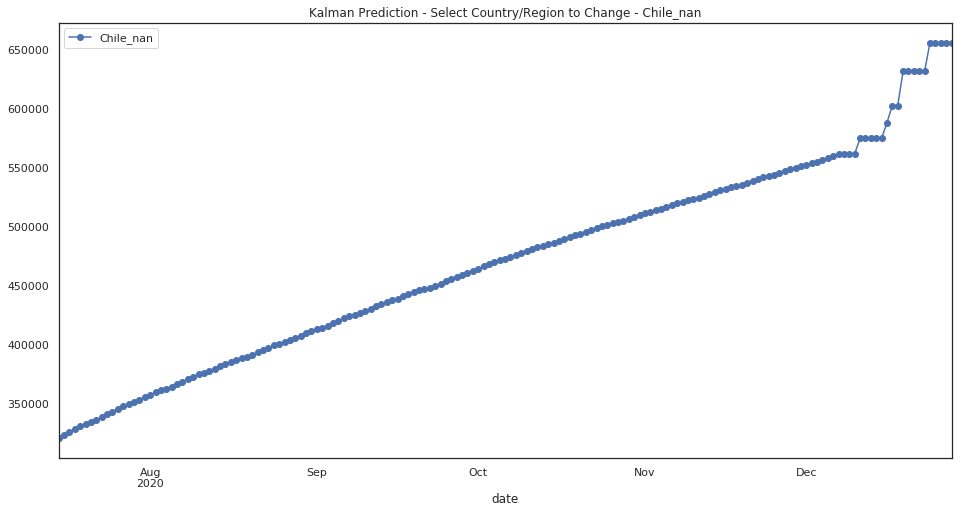

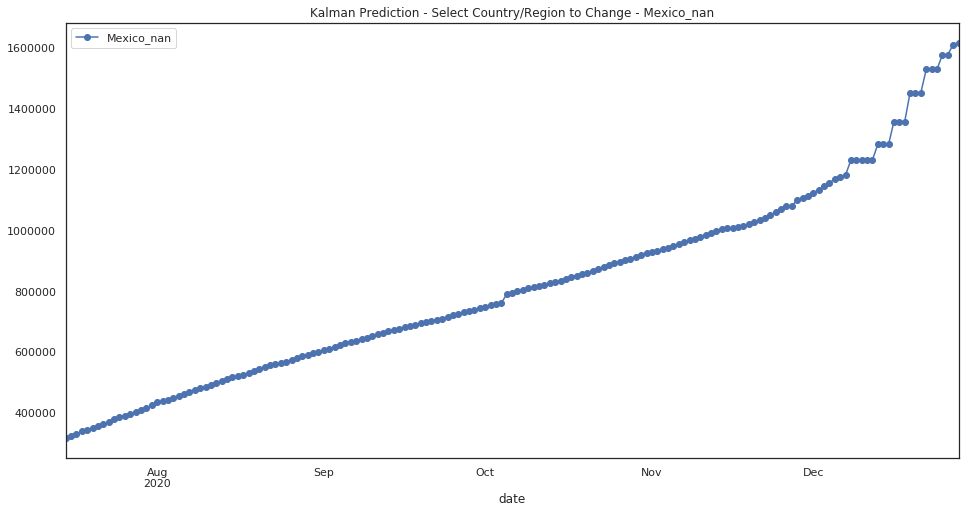

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-12-28 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      18107523.0
India_nan                                   NaN      11026098.0
Brazil_nan                                  NaN       7992502.0
Russia_nan                                  NaN       3155198.0
France_nan                                  NaN       3035988.0
Italy_nan                                   NaN       2340130.0
United Kingdom_nan                          NaN       1967936.0
Spain_nan                                   NaN       1959109.0
Colombia_nan                                NaN       1729225.0
Germany_nan                                 NaN       1668870.0
Argentina_nan                               NaN       1660397.0
Mexico_nan                                  NaN       1617285.0
Poland_nan                                  NaN       1533197.0
Iran_nan                                    NaN       1493459.0
Peru_nan                                    NaN       1312738.0
Turkey_nan                                  NaN       1216208.0
South Africa_nan                            NaN       1167570.0
Ukraine_nan                                 NaN        947861.0
Belgium_nan                                 NaN        819581.0
Netherlands_nan                             NaN        691930.0
Czechia_nan                                 NaN        685993.0
Iraq_nan                                    NaN        658826.0
Chile_nan                                   NaN        656356.0
Indonesia_nan                               NaN        635953.0
Romania_nan                                 NaN        635760.0
Bangladesh_nan                              NaN        613863.0
Philippines_nan                             NaN        526030.0
Portugal_nan                                NaN        490490.0
Pakistan_nan                                NaN        487191.0
Switzerland_nan                             NaN        480330.0
...                                         ...             ...
Saint Vincent and the Grenadines_nan        NaN           107.0
Dominica_nan                                NaN            98.0
Australia_Northern Territory                NaN            91.0
China_Ningxia                               NaN            85.0
Canada_Yukon                                NaN            72.0
Fiji_nan                                    NaN            57.0
Grenada_nan                                 NaN            52.0
China_Macau                                 NaN            52.0
Laos_nan                                    NaN            49.0
France_New Caledonia                        NaN            40.0
Saint Kitts and Nevis_nan                   NaN            36.0
Timor-Leste_nan                             NaN            34.0
Holy See_nan                                NaN            33.0
China_Qinghai                               NaN            24.0
United Kingdom_Anguilla                     NaN            21.0
France_Saint Pierre and Miquelon            NaN            21.0
Canada_Northwest Territories                NaN            21.0
Denmark_Greenland                           NaN            20.0
Solomon Islands_nan                         NaN            19.0
United Kingdom_Falkland Islands (Malvinas)  NaN            17.0
Canada_Repatriated Travellers               NaN            16.0
United Kingdom_Montserrat                   NaN            16.0
Canada_Grand Princess                       NaN            13.0
Western Sahara_nan                          NaN            10.0
MS Zaandam_nan                              NaN             9.0
Marshall Islands_nan                        NaN             4.0
Samoa_nan                                   NaN             2.0
China_Tibet                                 NaN             1.0
Vanuatu_nan                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[272 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          40094.0      12868.0      27703.0      10349.0   
2020-07-16          40160.0      12954.0      28213.0      10362.0   
2020-07-17          35060.0       3851.0      21355.0        877.0   
2020-07-18          35219.0       3906.0      21948.0        880.0   
2020-07-19          35279.0       4008.0      22815.0        880.0   
2020-07-20          35453.0       4090.0      23420.0        880.0   
2020-07-21          35493.0       4171.0      24010.0        884.0   
2020-07-22          35605.0       4290.0      24608.0        884.0   
2020-07-23          35938.0       4451.0      25468.0        889.0   
2020-07-24          36028.0       4481.0      26137.0        904.0   
2020-07-25          36063.0       4570.0      26755.0        897.0   
2020-07-26          36171.0       4755.0      27354.0        908.0   
2020-07-27          36285.0       4767.0      27968.0        917.0   
2020-07-28          36389.0       4910.0      28607.0        907.0   
2020-07-29          36496.0       5031.0      29228.0        931.0   
2020-07-30          36569.0       5142.0      29834.0        918.0   
2020-07-31          36691.0       5247.0      30403.0        922.0   
2020-08-01          36745.0       5377.0      30958.0        925.0   
2020-08-02          36737.0       5439.0      31478.0        936.0   
2020-08-03          36765.0       5546.0      31982.0        944.0   
2020-08-04          36803.0       5711.0      32511.0        937.0   
2020-08-05          36850.0       5809.0      33063.0        939.0   
2020-08-06          36953.0       5931.0      33636.0        957.0   
2020-08-07          37044.0       6090.0      34175.0        944.0   
2020-08-08          37087.0       6210.0      34710.0        955.0   
2020-08-09          37120.0       6360.0      35188.0        971.0   
2020-08-10          37183.0       6474.0      35720.0        974.0   
2020-08-11          37288.0       6628.0      36229.0        963.0   
2020-08-12          37373.0       6754.0      36717.0        983.0   
2020-08-13          37455.0       6908.0      37209.0        977.0   
...                     ...          ...          ...          ...   
2020-11-30          46317.0      38161.0      83260.0       6712.0   
2020-12-01          46532.0      38926.0      84206.0       6745.0   
2020-12-02          46756.0      39688.0      85136.0       6790.0   
2020-12-03          46877.0      40440.0      85985.0       6842.0   
2020-12-04          46878.0      41254.0      86770.0       6904.0   
2020-12-05          47058.0      42093.0      87537.0       6955.0   
2020-12-06          47332.0      42940.0      88283.0       7005.0   
2020-12-07          47548.0      43655.0      88876.0       7050.0   
2020-12-08          47576.0      44026.0      92659.0       7084.0   
2020-12-09          48762.0      46627.0      95963.0       7084.0   
2020-12-10          49203.0      48953.0      95555.0       7084.0   
2020-12-11          48947.0      48997.0      95082.0       7330.0   
2020-12-12          48947.0      49449.0      95165.0       7330.0   
2020-12-13          48922.0      50745.0      98027.0       7330.0   
2020-12-14          48922.0      52761.0     103978.0       7330.0   
2020-12-15          48922.0      53216.0     106338.0       7402.0   
2020-12-16          50054.0      52944.0     105492.0       7809.0   
2020-12-17          50497.0      54439.0     106074.0       7809.0   
2020-12-18          50255.0      55042.0     106479.0       7809.0   
2020-12-19          50255.0      56364.0     110007.0       7844.0   
2020-12-20          50222.0      57045.0     116643.0       8054.0   
2020-12-21          50451.0      56761.0     119237.0       8054.0   
2020-12-22          50638.0      60036.0     118461.0       8054.0   
2020-12-23          52086.0      61336.0     119721.0       8236.0   
2020-12-24

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'France_nan',
 'Italy_nan',
 'United Kingdom_nan',
 'Spain_nan',
 'Colombia_nan',
 'Germany_nan',
 'Argentina_nan',
 'Mexico_nan',
 'Poland_nan',
 'Iran_nan',
 'Peru_nan',
 'Turkey_nan',
 'South Africa_nan',
 'Ukraine_nan',
 'Belgium_nan',
 'Netherlands_nan',
 'Czechia_nan',
 'Iraq_nan',
 'Chile_nan',
 'Indonesia_nan',
 'Romania_nan',
 'Bangladesh_nan',
 'Philippines_nan',
 'Portugal_nan',
 'Pakistan_nan',
 'Switzerland_nan',
 'Saudi Arabia_nan',
 'Austria_nan',
 'Morocco_nan',
 'Israel_nan',
 'Sweden_nan',
 'Nepal_nan',
 'Jordan_nan',
 'Hungary_nan',
 'Georgia_nan',
 'Serbia_nan',
 'Kazakhstan_nan',
 'Croatia_nan',
 'United Arab Emirates_nan',
 'Ecuador_nan',
 'Azerbaijan_nan',
 'Panama_nan',
 'Bulgaria_nan',
 'Japan_nan',
 'Guatemala_nan',
 'Belarus_nan',
 'Qatar_nan',
 'Dominican Republic_nan',
 'Kuwait_nan',
 'Canada_Quebec',
 'Bolivia_nan',
 'Lebanon_nan',
 'Costa Rica_nan',
 'Greece_nan',
 'Oman_nan',
 'Armenia_na

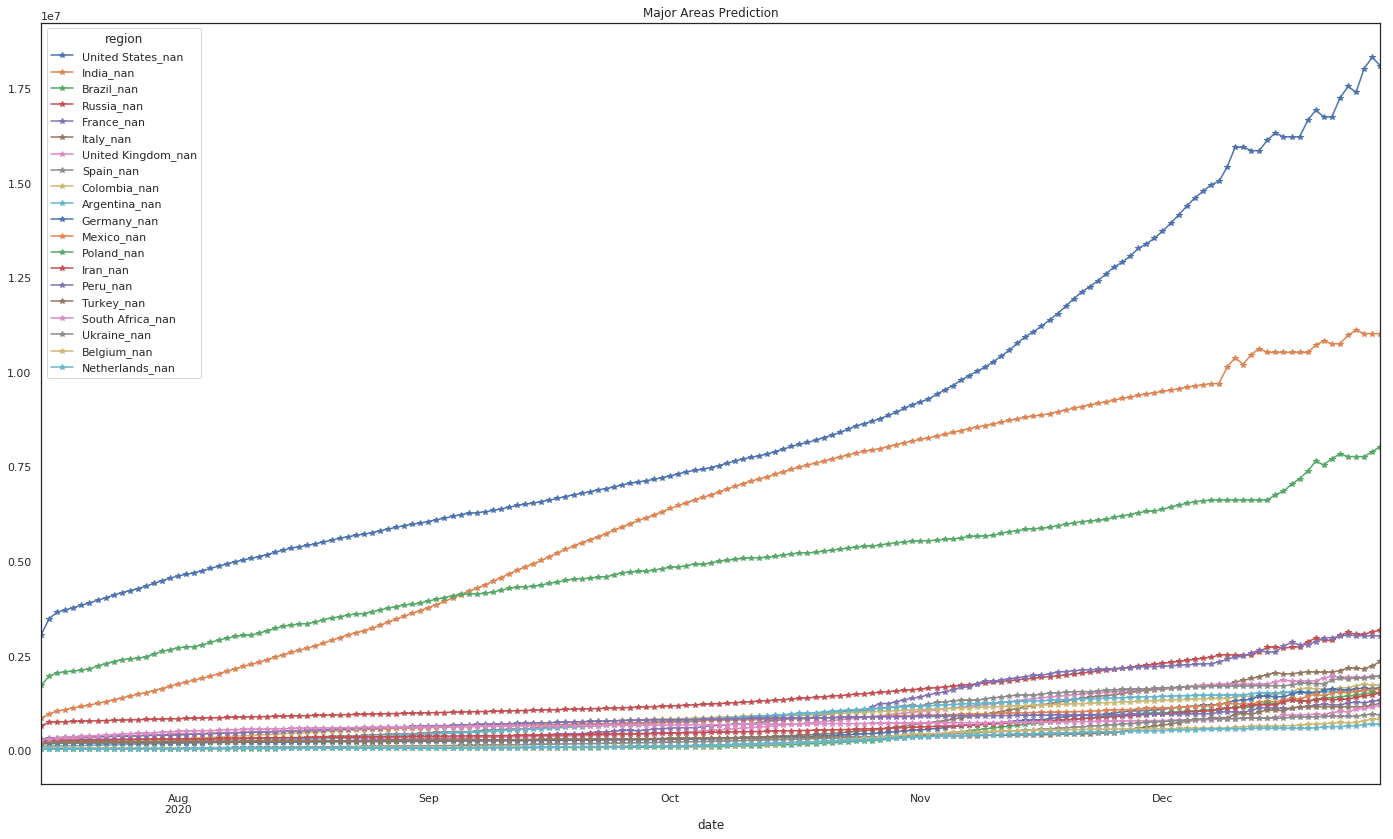

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

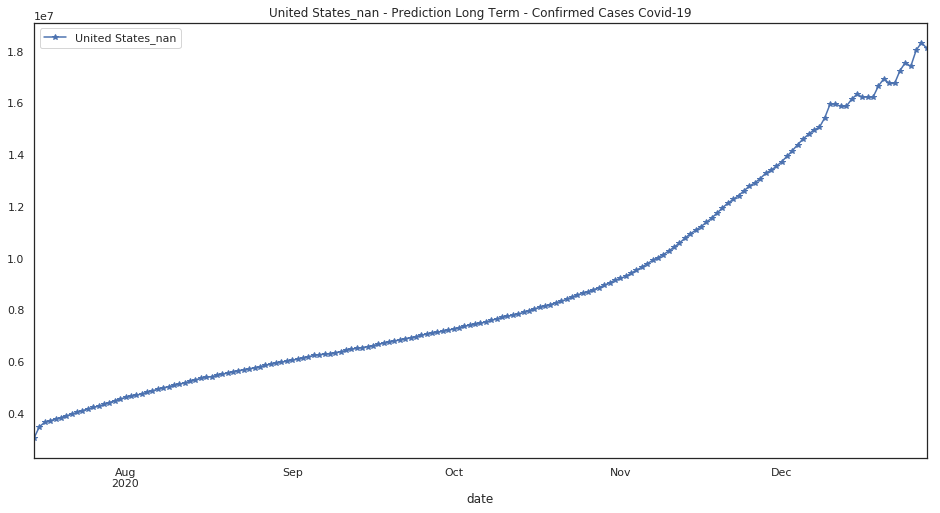

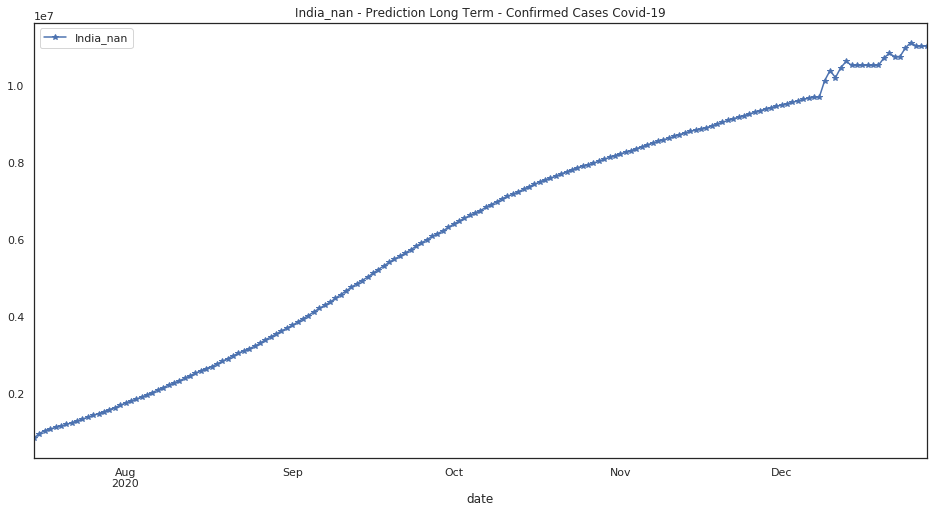

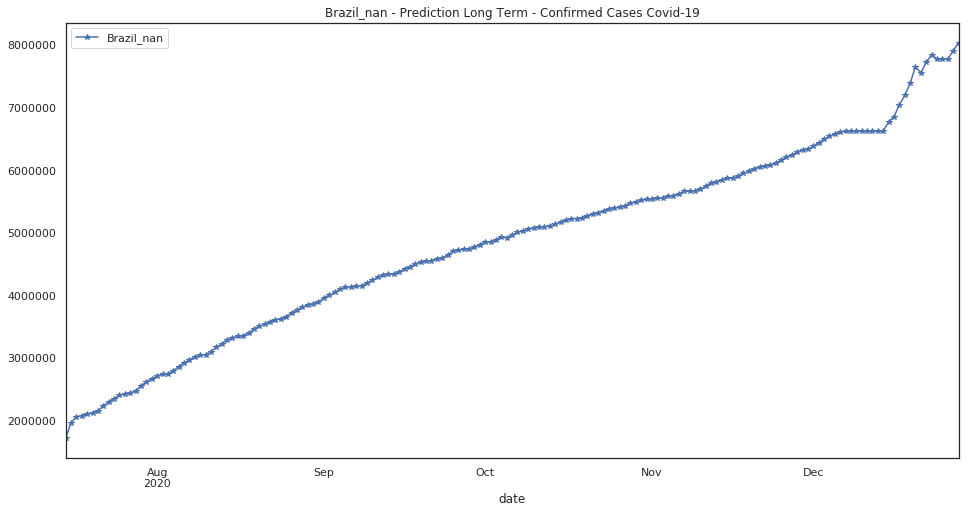

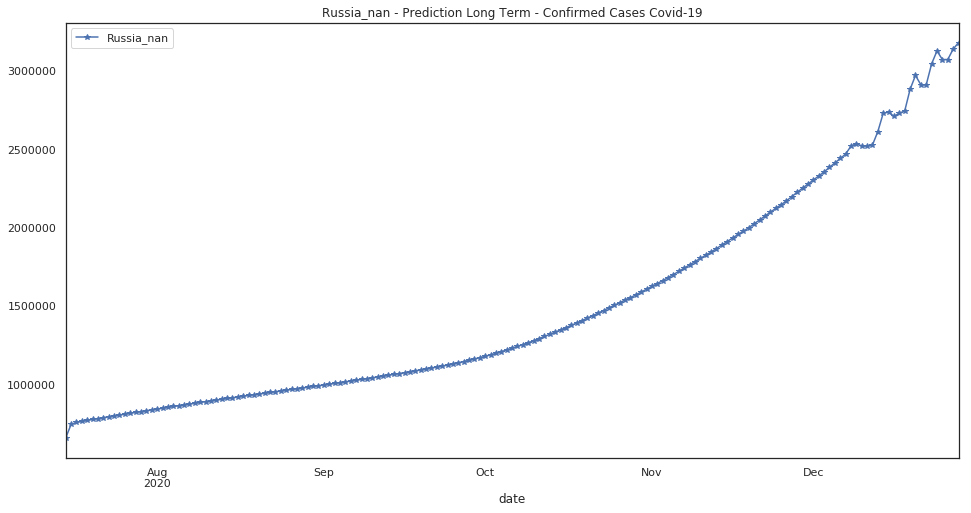

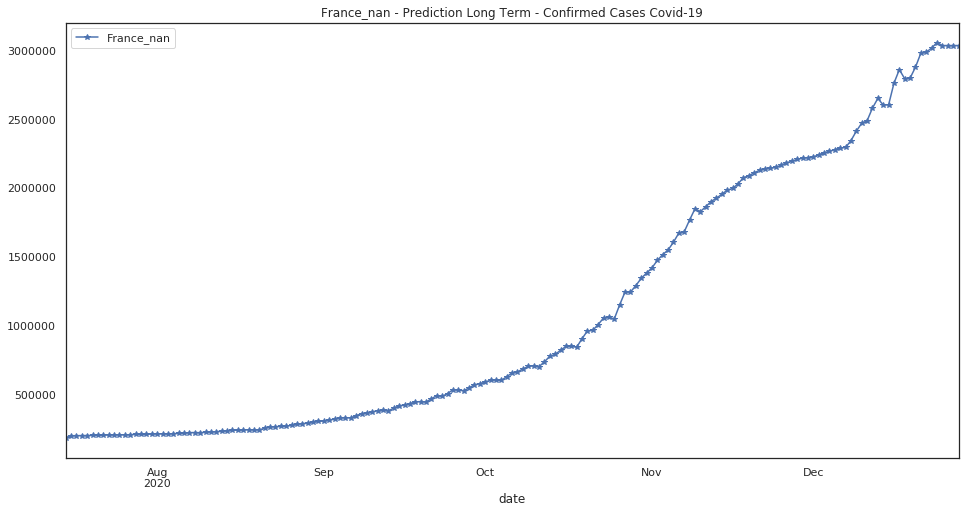

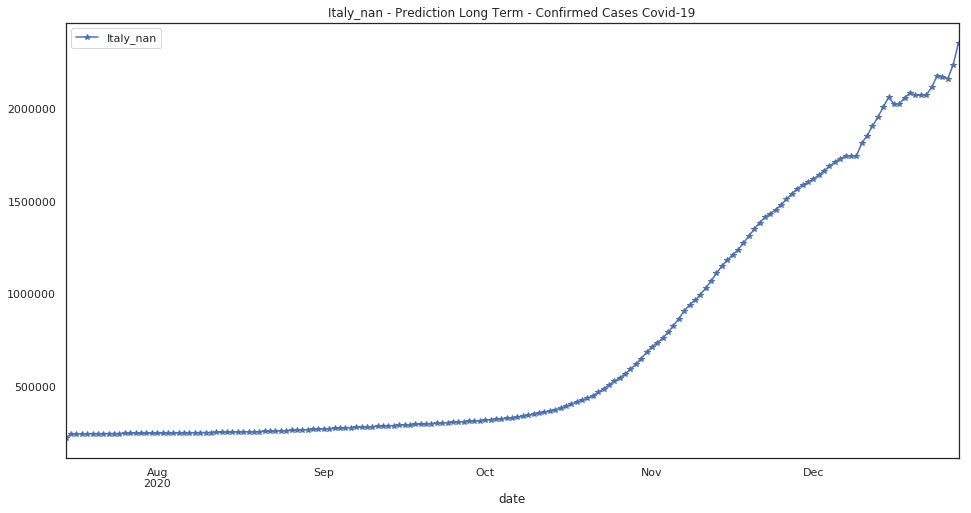

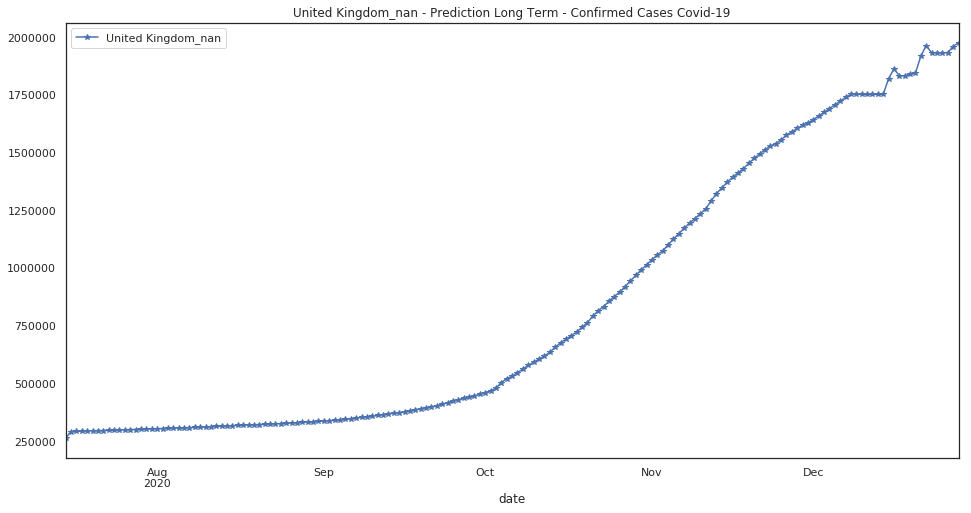

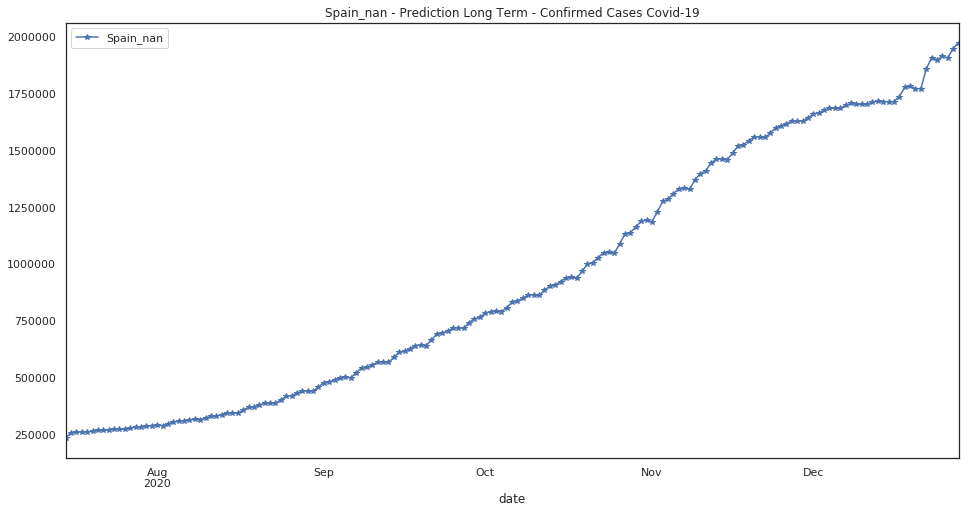

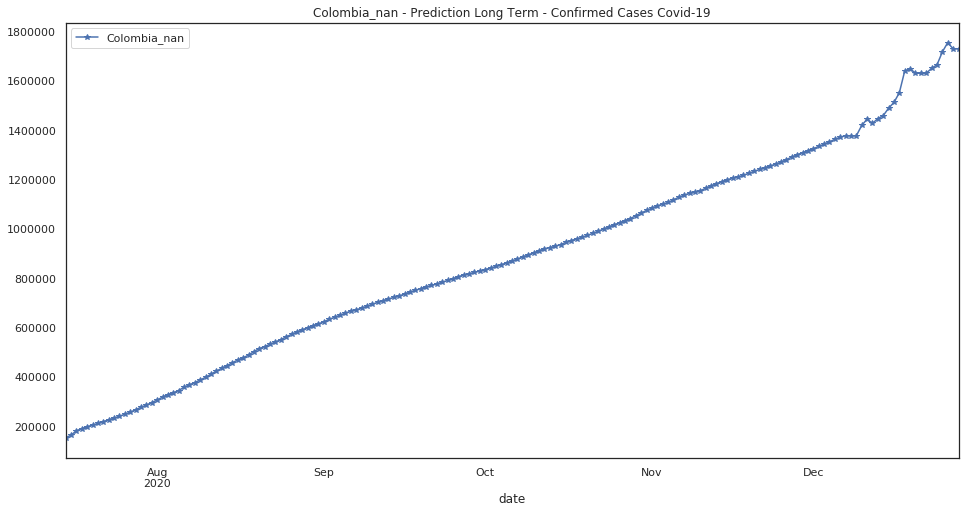

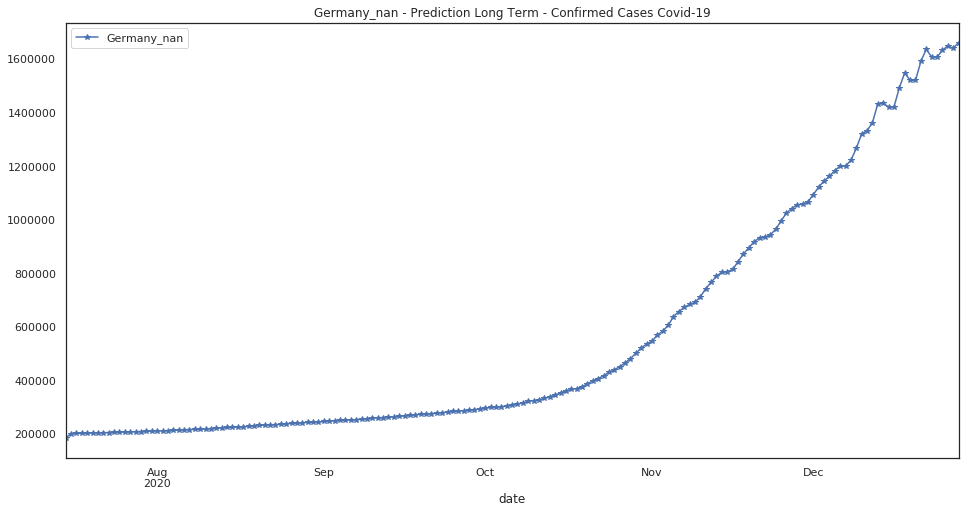

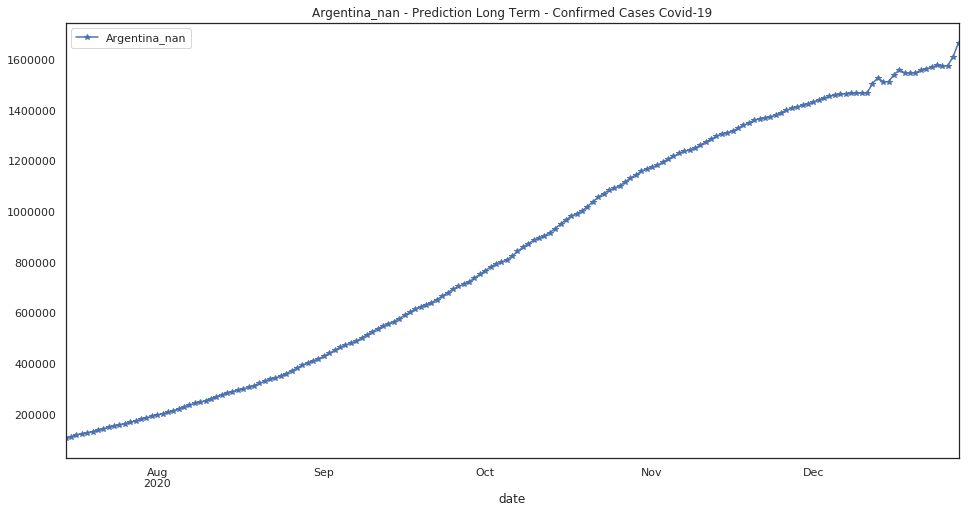

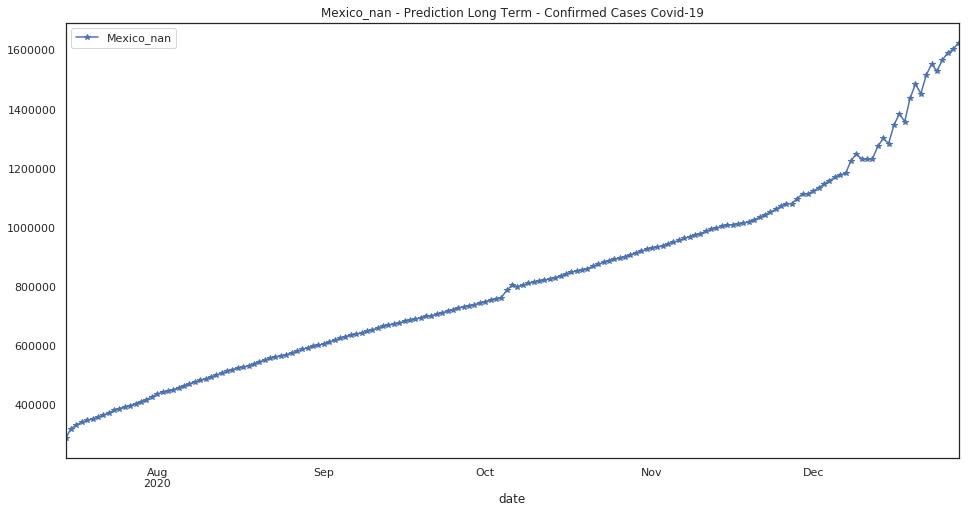

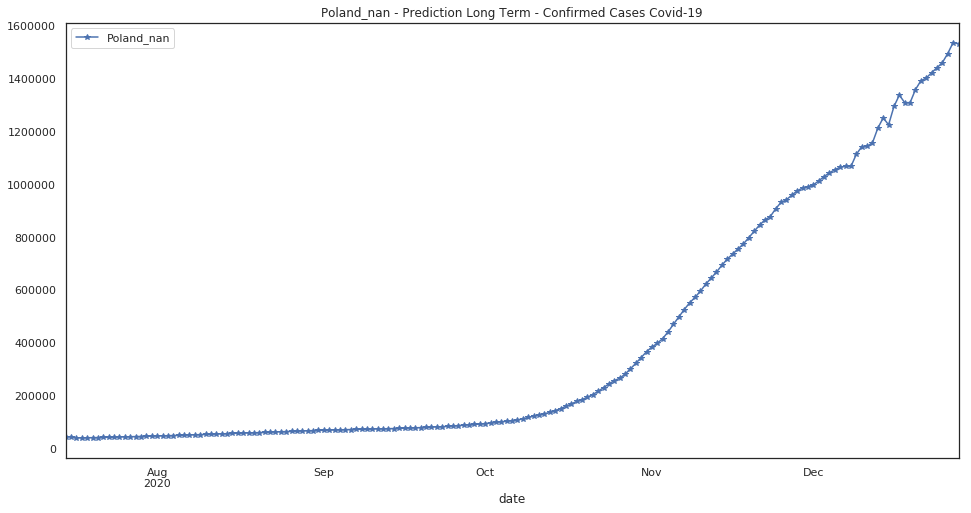

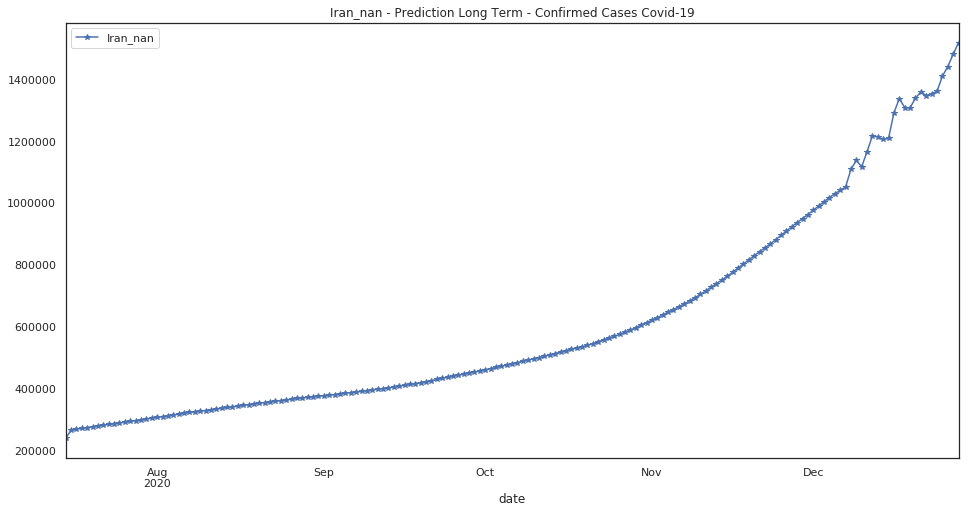

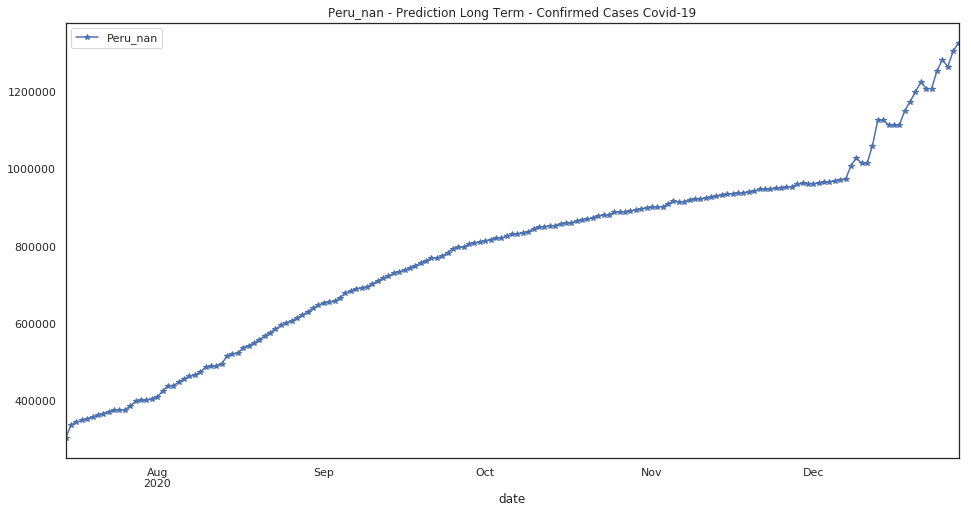

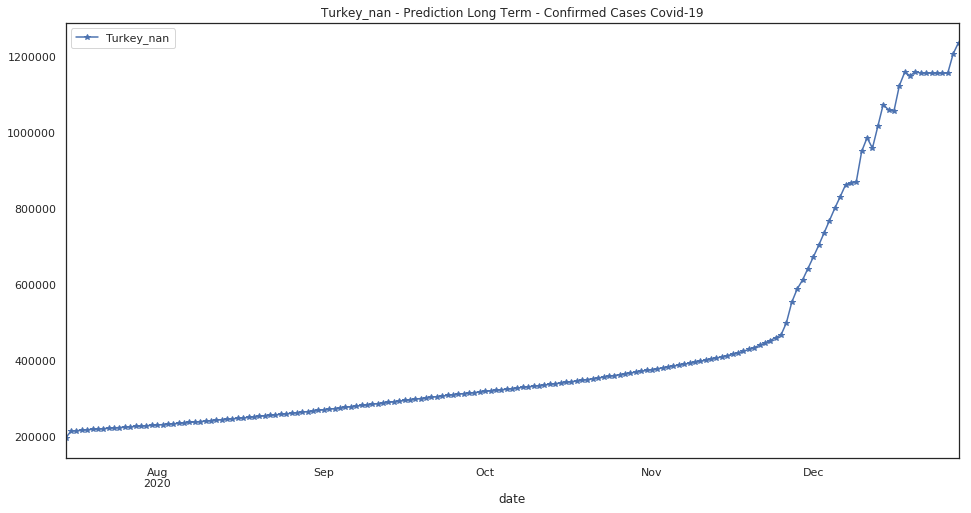

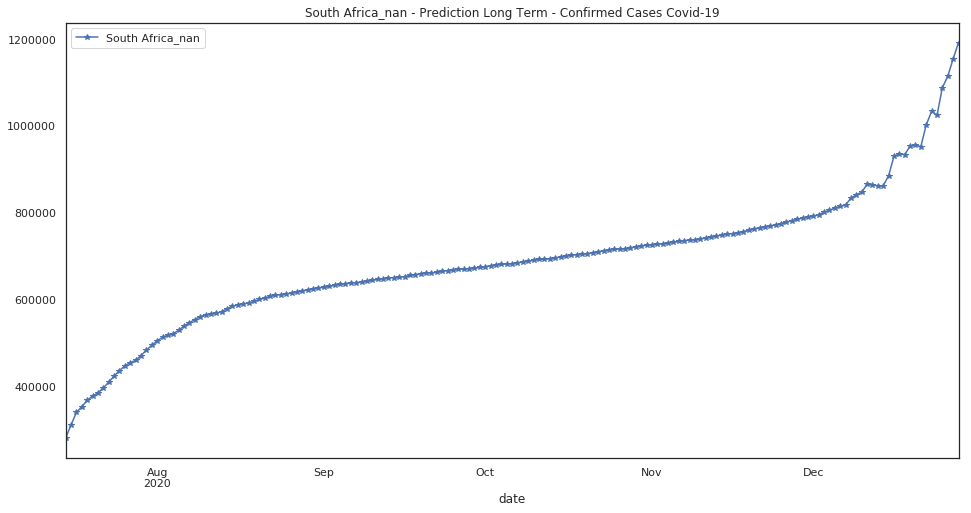

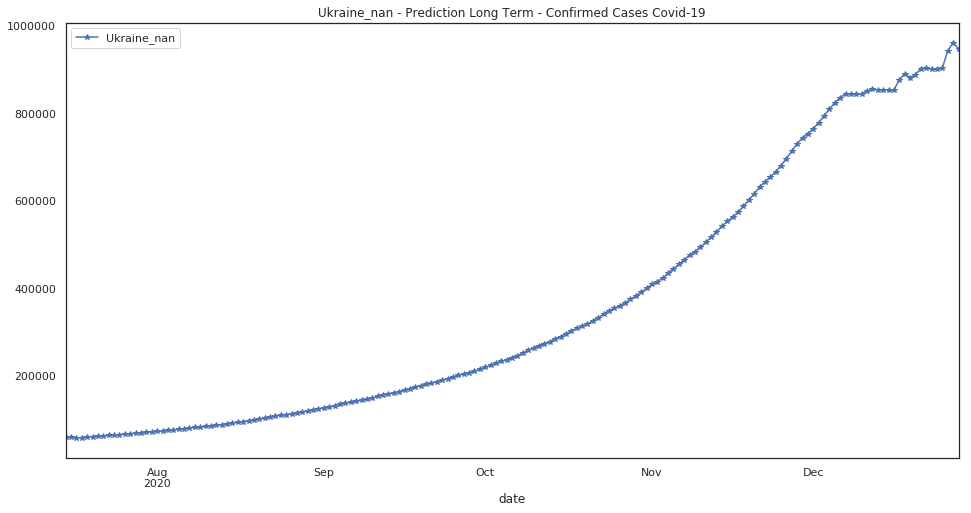

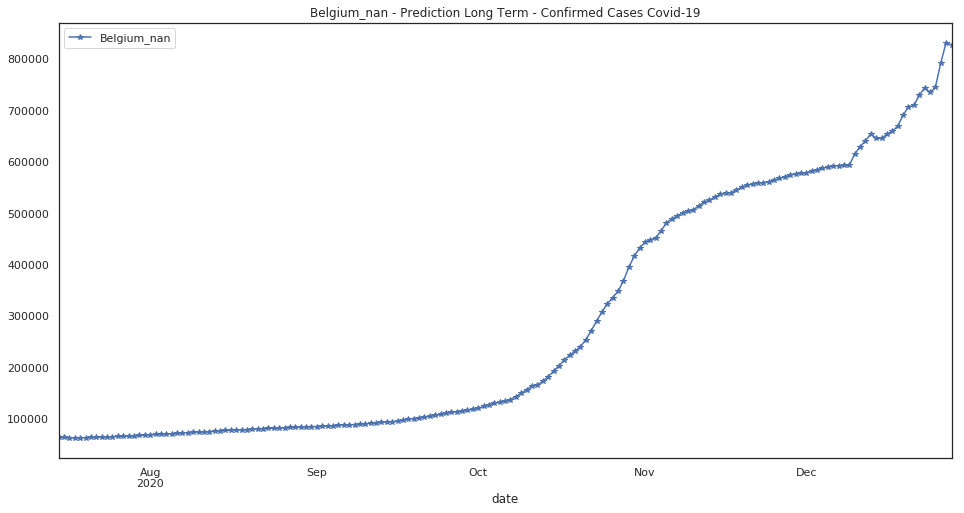

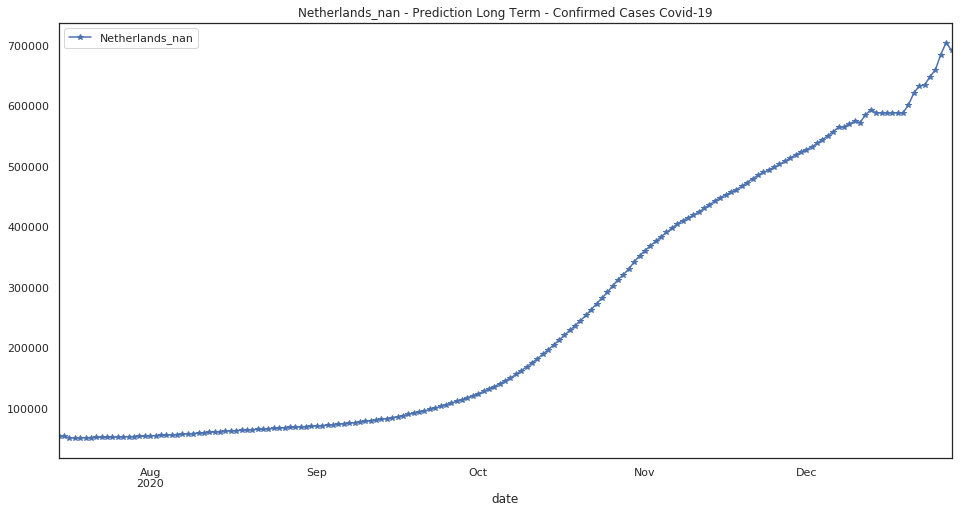

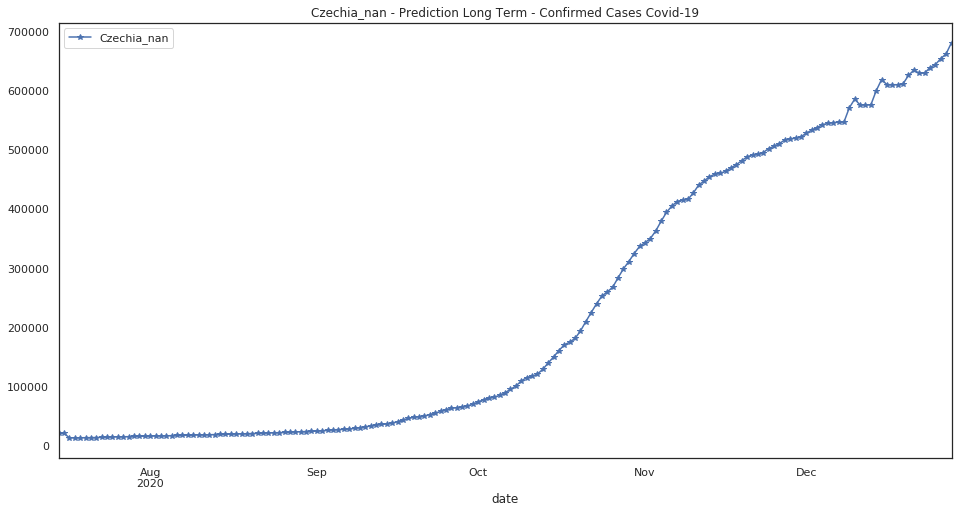

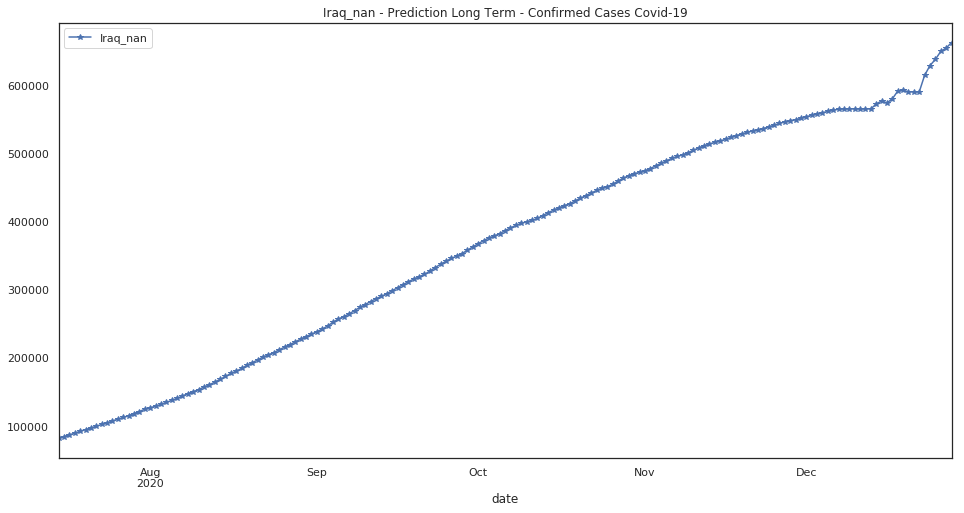

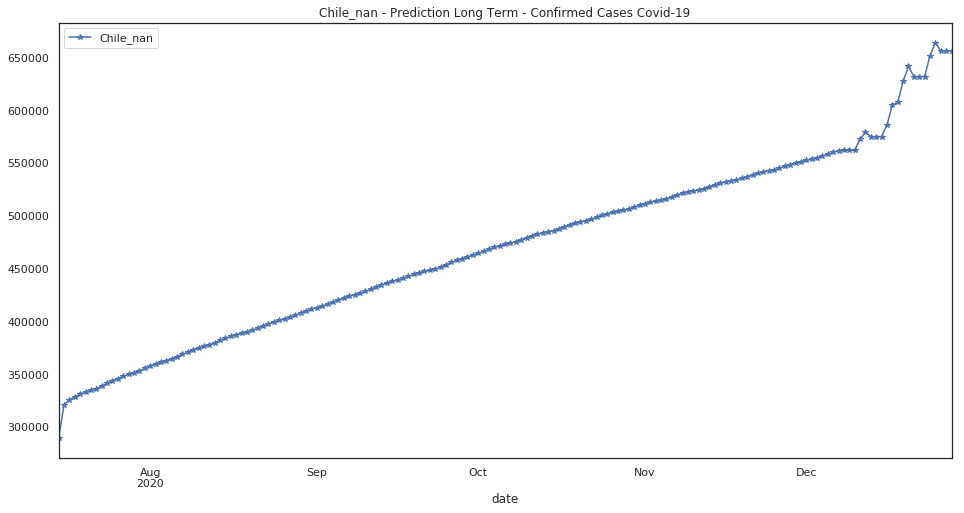

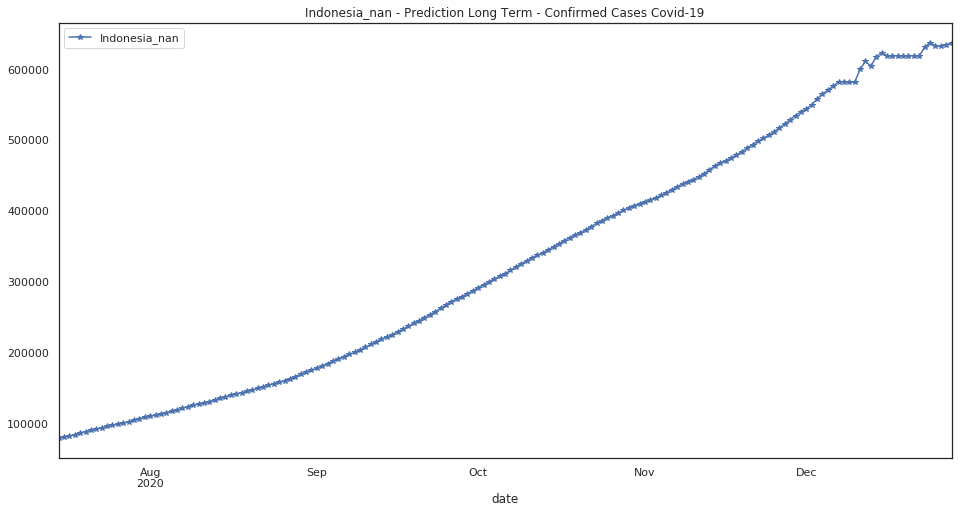

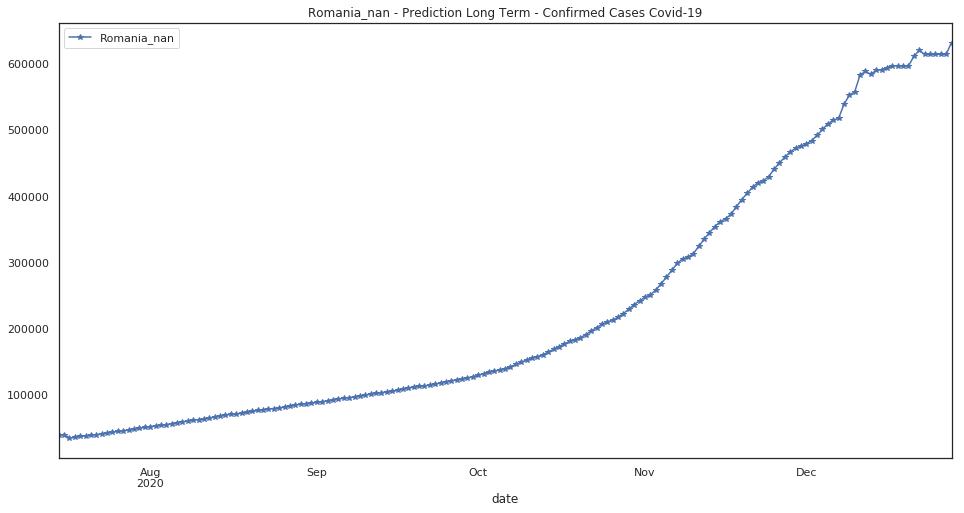

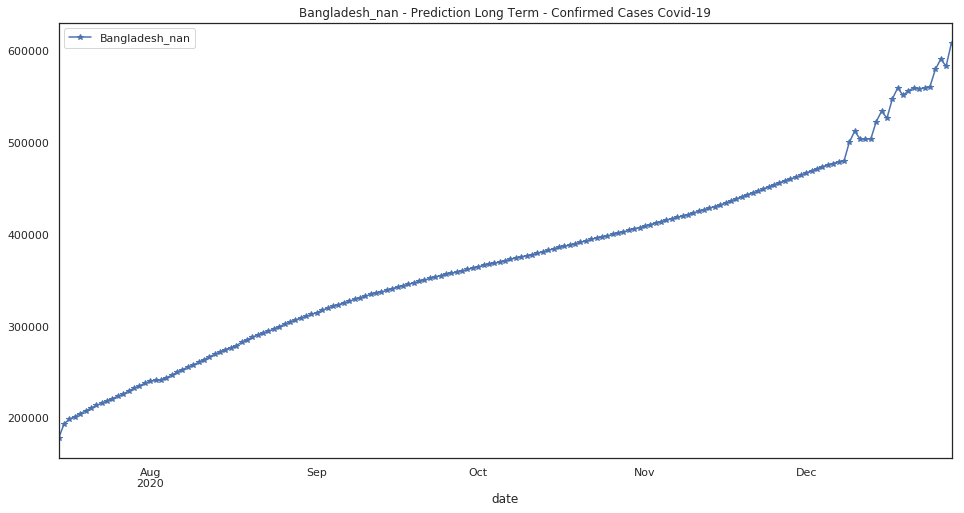

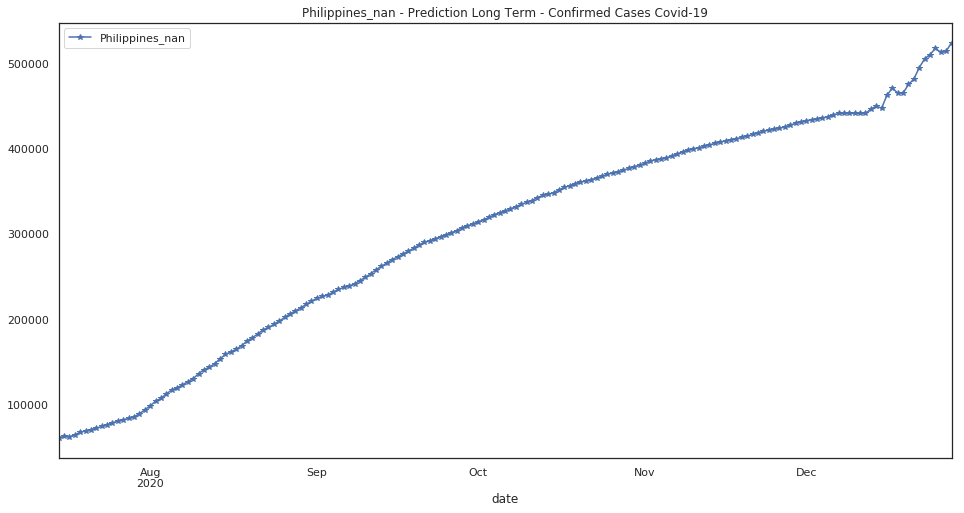

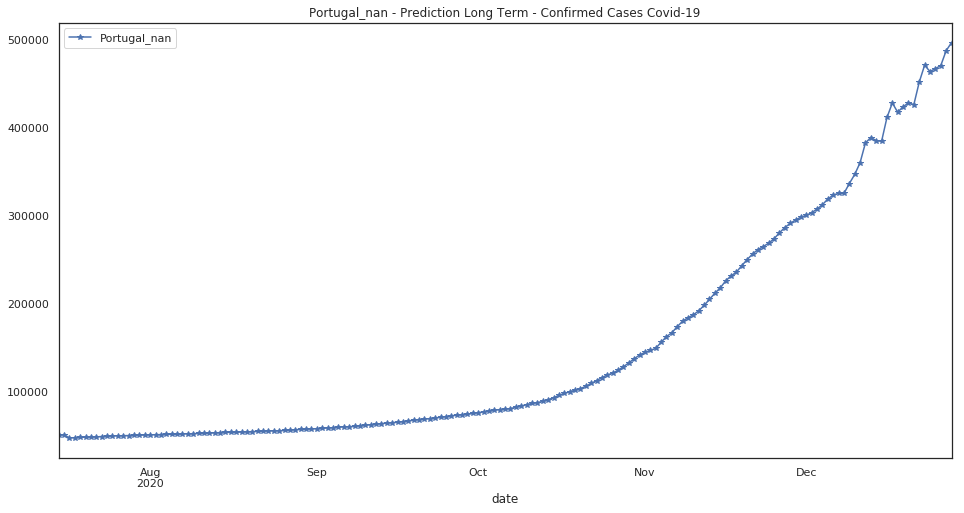

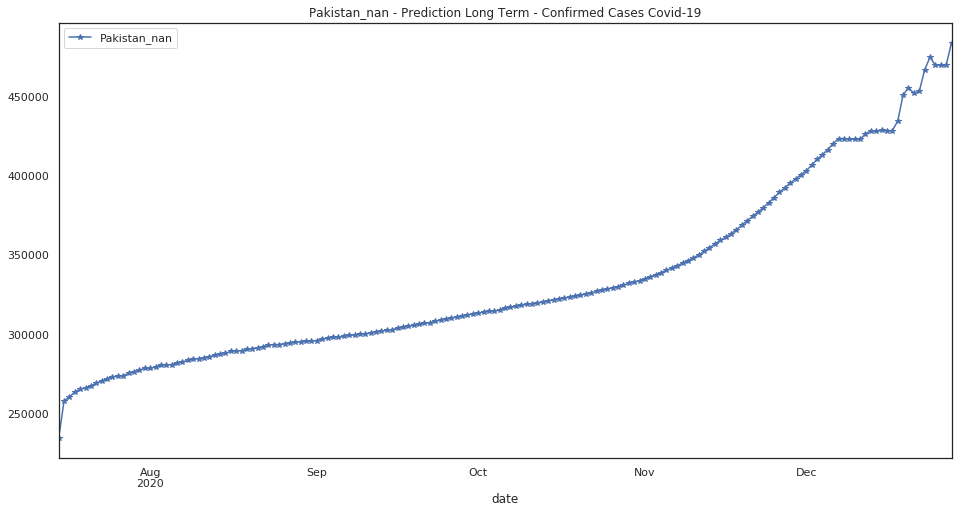

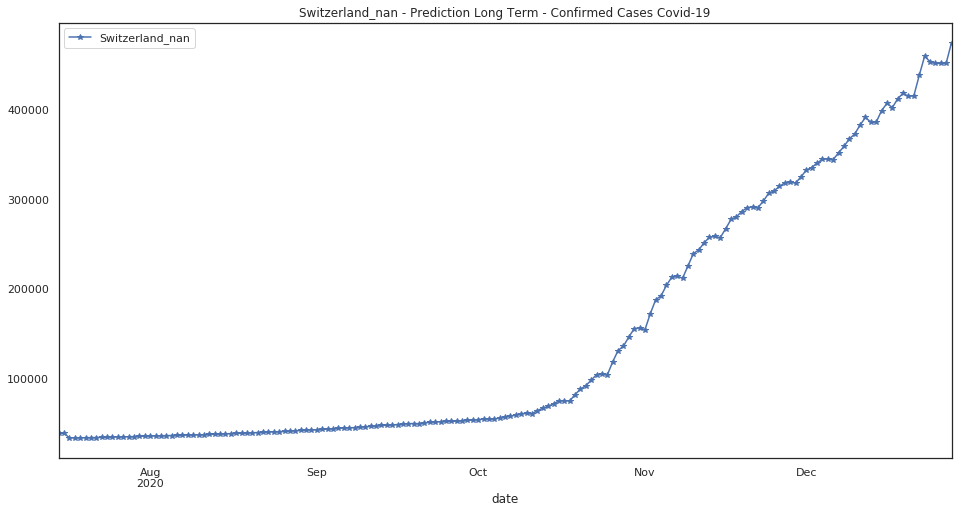

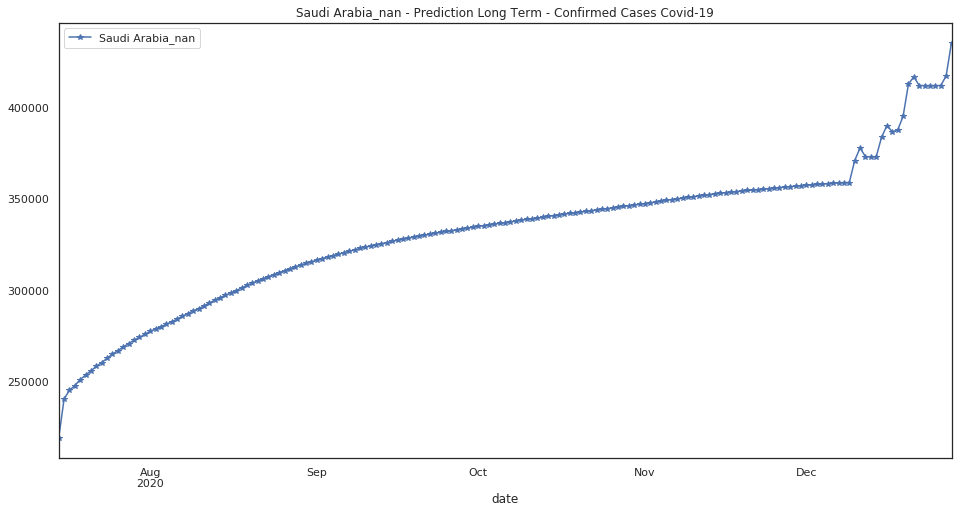

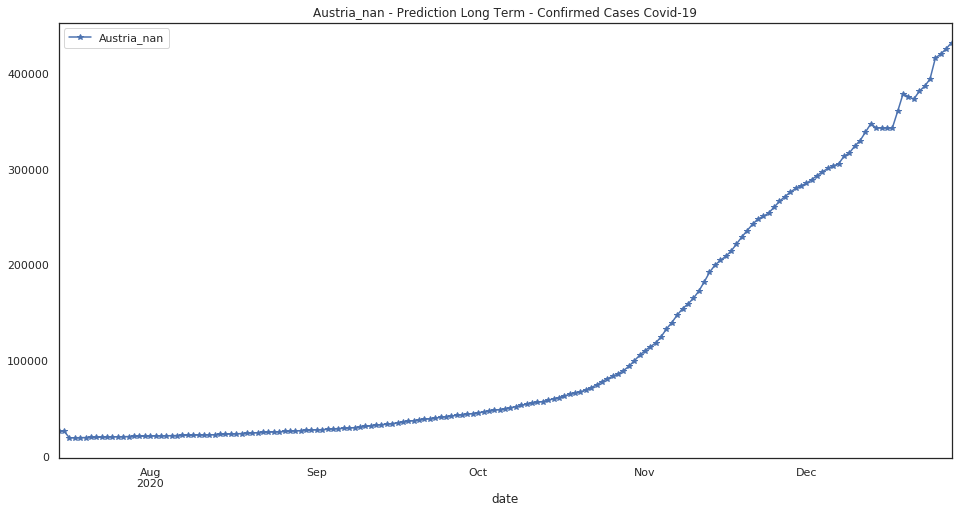

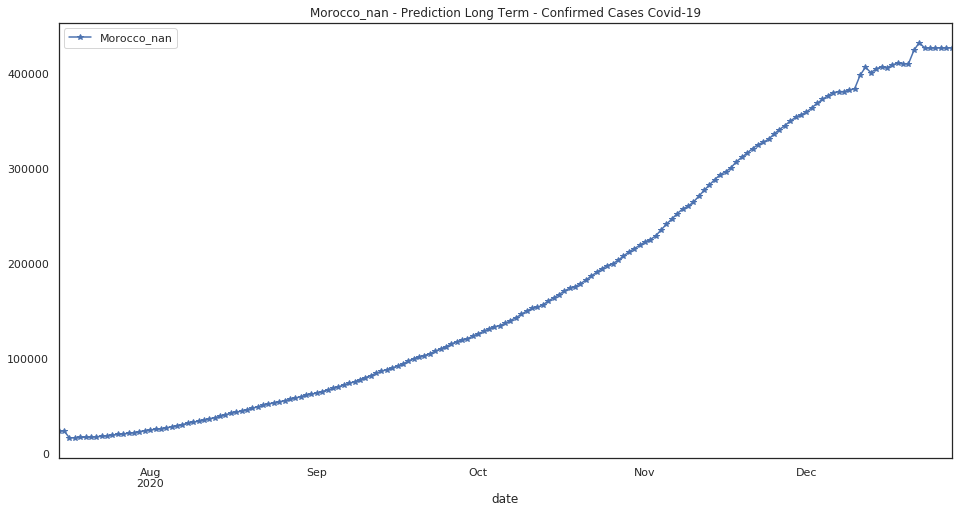

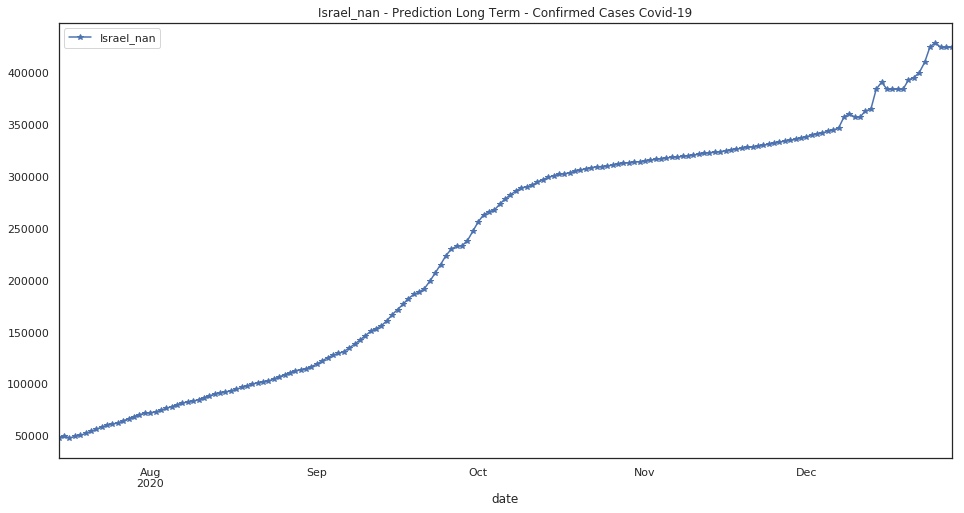

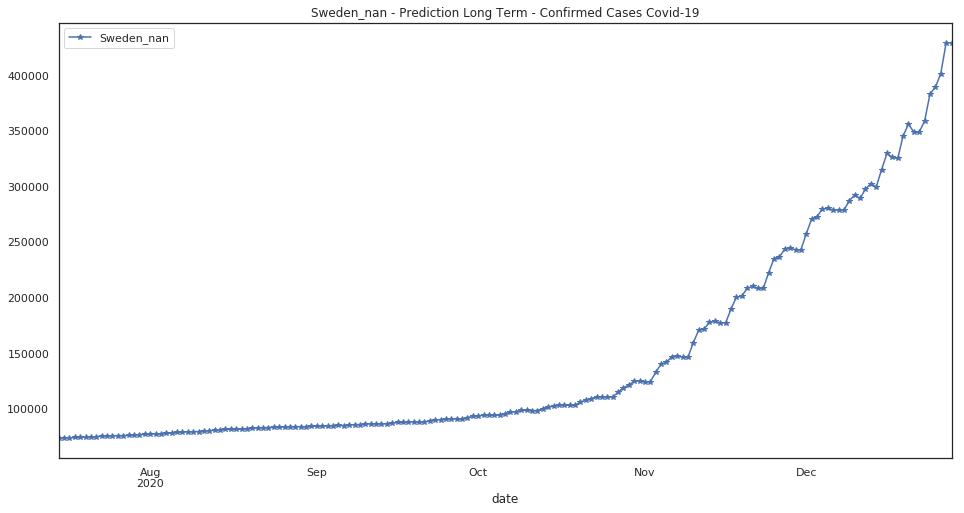

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

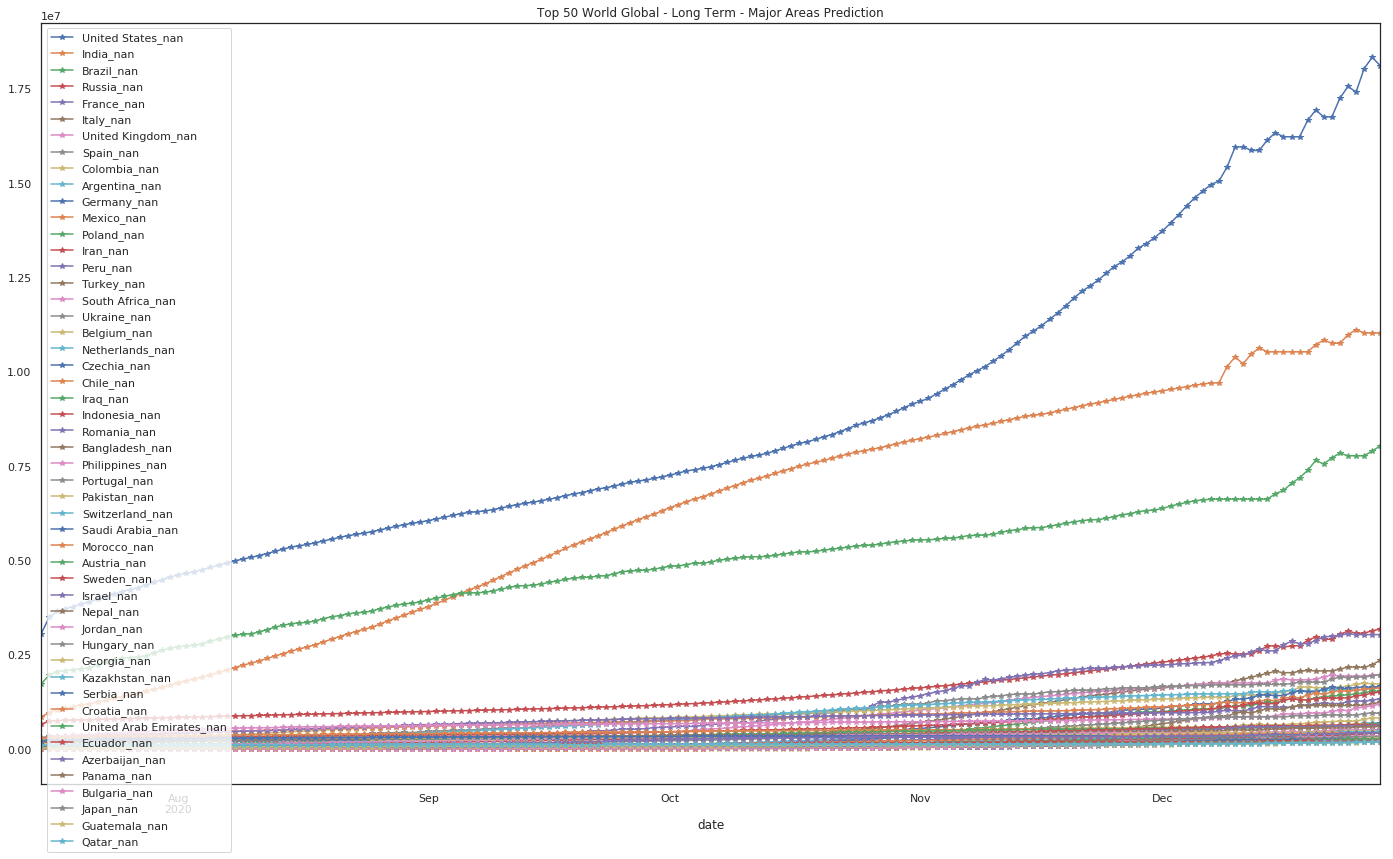

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

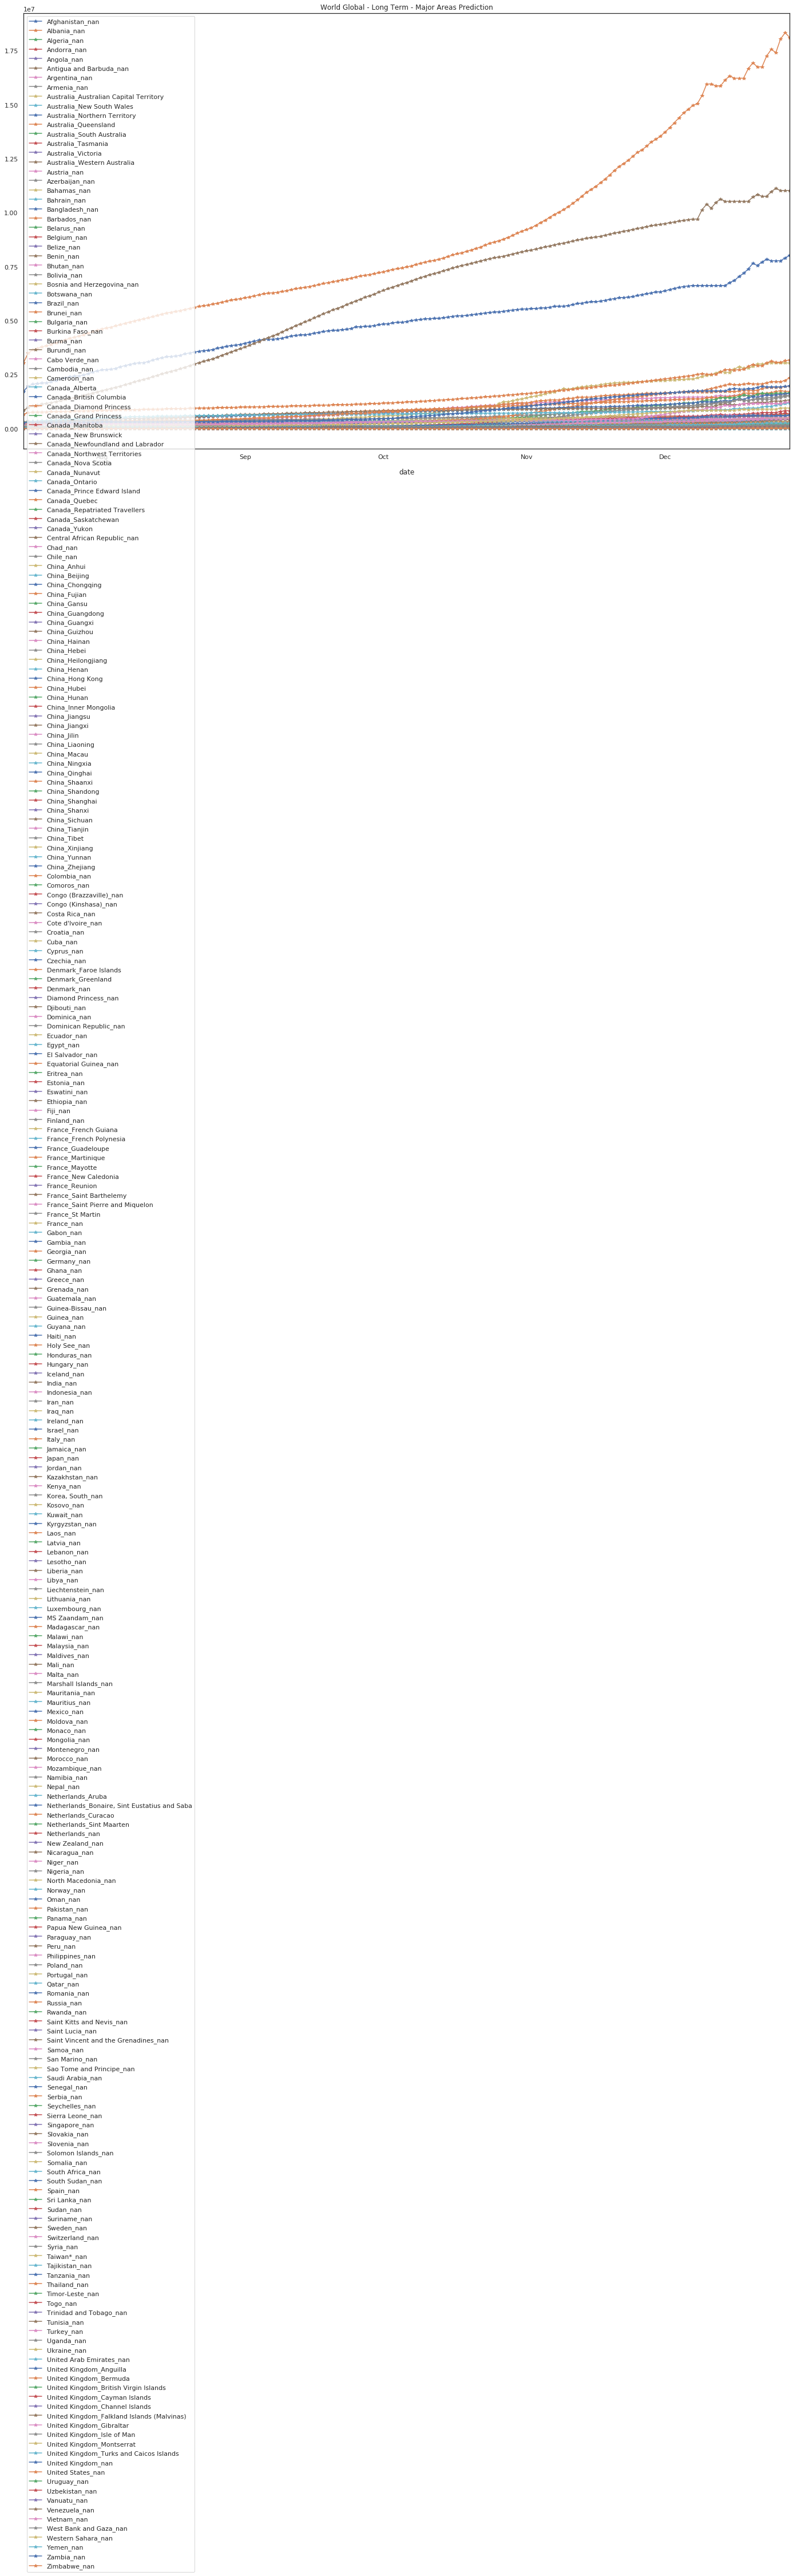

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38167.0       9280.0      43811.0       1124.0   
2020-08-30          38185.0       9391.0      44176.0       1143.0   
2020-08-31          38194.0       9501.0      44524.0       1189.0   
2020-09-01          38223.0       9578.0      44861.0       1176.0   
2020-09-02          38275.0       9725.0      45186.0       1184.0   
2020-09-03          38324.0       9823.0      45497.0       1199.0   
2020-09-04          38343.0       9948.0      45800.0       1228.0   
2020-09-05          38359.0      10080.0      46098.0       1215.0   
2020-09-06          38425.0      10225.0      46391.0       1221.0   
2020-09-07          38525.0      10369.0      46680.0       1261.0   
2020-09-08          38563.0      10522.0      46966.0       1261.0   
2020-09-09          38579.0      10677.0      47245.0       1312.0   
2020-09-10          38605.0      10831.0      47517.0       1301.0   
2020-09-11          38637.0      10990.0      47781.0       1352.0   
2020-09-12          38673.0      11153.0      48035.0       1344.0   
2020-09-13          38743.0      11321.0      48282.0       1361.0   
2020-09-14          38808.0      11488.0      48523.0       1443.0   
2020-09-15          38851.0      11644.0      48761.0       1438.0   
2020-09-16          38890.0      11796.0      48993.0       1523.0   
2020-09-17          38908.0      11933.0      49221.0       1483.0   
2020-09-18          38928.0      12062.0      49441.0       1567.0   
2020-09-19          38951.0      12213.0      49651.0       1564.0   
2020-09-20          39062.0      12359.0      49853.0       1594.0   
2020-09-21          39120.0      12510.0      50049.0       1696.0   
2020-09-22          39131.0      12650.0      50240.0       1681.0   
2020-09-23          39176.0      12779.0      50426.0       1781.0   
2020-09-24          39205.0      12913.0      50605.0       1753.0   
2020-09-25          39219.0      13032.0      50780.0       1836.0   
2020-09-26          39225.0      13146.0      50941.0       1836.0   
2020-09-27          39254.0      13258.0      51092.0       1841.0   
...                     ...          ...          ...          ...   
2020-11-29          46119.0      37534.0      82287.0       6610.0   
2020-11-30          46317.0      38161.0      83260.0       6712.0   
2020-12-01          46532.0      38926.0      84206.0       6745.0   
2020-12-02          46756.0      39688.0      85136.0       6790.0   
2020-12-03          46877.0      40440.0      85985.0       6842.0   
2020-12-04          46878.0      41254.0      86770.0       6904.0   
2020-12-05          47058.0      42093.0      87537.0       6955.0   
2020-12-06          47332.0      42940.0      88283.0       7005.0   
2020-12-07          47548.0      43655.0      88876.0       7050.0   
2020-12-08          47576.0      44026.0      92659.0       7084.0   
2020-12-09          48762.0      46627.0      95963.0       7084.0   
2020-12-10          49203.0      48953.0      95555.0       7084.0   
2020-12-11          48947.0      48997.0      95082.0       7330.0   
2020-12-12          48947.0      49449.0      95165.0       7330.0   
2020-12-13          48922.0      50745.0      98027.0       7330.0   
2020-12-14          48922.0      52761.0     103978.0       7330.0   
2020-12-15          48922.0      53216.0     106338.0       7402.0   
2020-12-16          50054.0      52944.0     105492.0       7809.0   
2020-12-17          50497.0      54439.0     106074.0       7809.0   
2020-12-18          50255.0      55042.0     106479.0       7809.0   
2020-12-19          50255.0      56364.0     110007.0       7844.0   
2020-12-20          50222.0      57045.0     116643.0       8054.0   
2020-12-21          50451.0      56761.0     119237.0       8054.0   
2020-12-22          50638.0      60036.0     118461.0       8054.0   
2020-12-23

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
248                             Timor-Leste_nan  -8.874217  125.727539   
249                                    Togo_nan   8.619500    0.824800   
250                     Trinidad and Tobago_nan  10.691800  -61.222500   
251                                 Tunisia_nan  33.886917    9.537499   
252                                  Turkey_nan  38.963700   35.243300   
253                           United States_nan  40.000000 -100.000000   
254                                  Uganda_nan   1.373333   32.290275   
255                                 Ukraine_nan  48.379400   31.165600   
256                    United Arab Emirates_nan  23.424076   53.847818   
257                     United Kingdom_Anguilla  18.220600  -63.068600   
258                      United Kingdom_Bermuda  32.307800  -64.750500   
259       United Kingdom_British Virgin Islands  18.420700  -64.640000   
260               United Kingdom_Cayman Islands  19.313300  -81.254600   
261              United Kingdom_Channel Islands  49.372300   -2.364400   
262  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
263                    United Kingdom_Gibraltar  36.140800   -5.353600   
264                  United Kingdom_Isle of Man  54.236100   -4.548100   
265                   United Kingdom_Montserrat  16.742498  -62.187366   
266     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
267                          United Kingdom_nan  55.378100   -3.436000   
268                                 Uruguay_nan -32.522800  -55.765800   
269                              Uzbekistan_nan  41.377491   64.585262   
270                                 Vanuatu_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

ValueError: Location values cannot contain NaNs.

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      17            Azerbaijan_nan  40.143100   47.576900   
3      20            Bangladesh_nan  23.685000   90.356300   
4      22               Belarus_nan  53.709800   27.953400   
5      23               Belgium_nan  50.833300    4.469936   
6      30                Brazil_nan -14.235000  -51.925300   
7      32              Bulgaria_nan  42.733900   25.485800   
8      59                 Chile_nan -35.675100  -71.543000   
9      93              Colombia_nan   4.570900  -74.297300   
10     99               Croatia_nan  45.100000   15.200000   
11    102               Czechia_nan  49.817500   15.473000   
12    110               Ecuador_nan  -1.831200  -78.183400   
13    130                France_nan  46.227600    2.213700   
14    133               Georgia_nan  42.315400   43.356900   
15    134               Georgia_nan  42.315400   43.356900   
16    135               Germany_nan  51.165691   10.451526   
17    139             Guatemala_nan  15.783500  -90.230800   
18    147               Hungary_nan  47.162500   19.503300   
19    149                 India_nan  20.593684   78.962880   
20    150             Indonesia_nan  -0.789300  113.921300   
21    151                  Iran_nan  32.427908   53.688046   
22    152                  Iraq_nan  33.223191   43.679291   
23    154                Israel_nan  31.046051   34.851612   
24    155                Israel_nan  31.046051   34.851612   
25    156                 Italy_nan  41.871940   12.567380   
26    158                 Japan_nan  36.204824  138.252924   
27    159                Jordan_nan  31.240000   36.510000   
28    160            Kazakhstan_nan  48.019600   66.923700   
29    186                Mexico_nan  23.634500 -102.552800   
30    191               Morocco_nan  31.791700   -7.092600   
31    194                 Nepal_nan  28.166700   84.250000   
32    199           Netherlands_nan  52.132600    5.291300   
33    207              Pakistan_nan  30.375300   69.345100   
34    208                Panama_nan   8.538000  -80.782100   
35    211                  Peru_nan  -9.190000  -75.015200   
36    212           Philippines_nan  12.879721  121.774017   
37    213                Poland_nan  51.919400   19.145100   
38    214              Portugal_nan  39.399900   -8.224500   
39    216               Romania_nan  45.943200   24.966800   
40    217                Russia_nan  61.524010  105.318756   
41    225          Saudi Arabia_nan  23.885942   45.079162   
42    227                Serbia_nan  44.016500   21.005900   
43    235          South Africa_nan -30.559500   22.937500   
44    237                 Spain_nan  40.463667   -3.749220   
45    241                Sweden_nan  60.128161   18.643501   
46    242           Switzerland_nan  46.818200    8.227500   
47    252                Turkey_nan  38.963700   35.243300   
48    253         United States_nan  40.000000 -100.000000   
49    255               Ukraine_nan  48.379400   31.165600   
50    256  United Arab Emirates_nan  23.424076   53.847818   
51    267        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              106488.0             111146.0             118800.0   
1               26295.0              26396.0              19270.0   
2               31977.0              32406.0              26165.0   
3              178358.0             193590.0             198827.0   
4               66647.0              66804.0              65623.0   
5               64405.0              64724.0              63238.0   
6             1724096.0            1966748.0            2057461.0   
7               16464.0              16697.0               8144.0   
8              289605.0             321205.0             325730.0   
9              153582.0    

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()